In [1]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(5308)
tf.random.set_seed(5308)

In [2]:
#tf.config.list_physical_devices('GPU')

11501568/11490434 [==============================] - 0s 0us/step


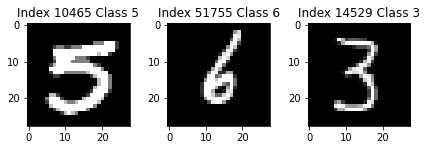

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

# Important
* Always have a validation set, the procedure to create validation or dev set is by performing random sample without replacement on train set and then only using that fraction as dev set. 
* Simple approach is to set some K samples, you can extract them from start, mid or end.
* Imagine validation set that partially approximates test set distribution and we assume our model would produce identical results when we test it on test set.
* Always optimize your hyperparameters by looking at performance on validation set and not test set.
* Do not touch test set, we have this to test how our model would work on unseen data.

In [4]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


# Points to remember
* If using any type of neural network, normalize your input between 0-1.
* One can use various procedures to achieve this, divide by largest value (for images we use 255), subtract mean from data and then normalize, one can even augment them and use other steps for normalization.
* Normalization is important step, one could observe significant boost in performance just by having better normalization scheme.
* For targets we always use one-hot encodings.

In [5]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [6]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


# Importance of weight initialization

* One reason backprop based models can perform bettter lies with the weight initialization method, one important point one should remember is that, if yur weights are initialized to be too high or low, backprop would struggle.
* Hence one should always carefully initialize weights of your model, below i have shown approach with random_normal, one can use random_uniform, truncated version of both, Xavier init and orthogonal. 
* You will find modern day NNs have achieved stable and better performance by simply switching to better init and majority of cases Xavier or Orthogonal works best.
* Always initialize your bias using zero or some small constant (ideally 0.01 or less works better). We use bias to shift the activation and in some cases it can stabalize learning, but having large bias can cause negative results.

# Loss function

* We will always cross-entropy loss for classification.

* tf softmax,
loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf)), this function is simply saying that it will calculate softmax for you, simply provide logits to it. 

* In other output of your forward pass directly goes this function. Now this operator will calculate or apply softmax over prediction or logits and calculate cross-entropy between prediction and target. I am using reduce_mean since we apply this over batches.
* Second is using keras
Method 1 :- This function requires logits, hence same as above you will pass logits or output variable to this function. Now remember you need from_logits = True, for this to work.
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss_x = cce(y_true_tf, y_pred_tf) 

* Method 2:- In this we will apply softmax to output function and then pass to CCE loss.
So the approach is 
output = tf.nn.softmax(output)
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
loss_x = cce(y_true_tf, y_pred_tf) 

# Define class to build mlp model with Adam or RMSProp or SGD optimizer

In [7]:
import sys
class MLP(object):
  def __init__(self, size_input=size_input, size_hidden1=size_hidden1, size_hidden2=size_hidden2, size_hidden3=size_hidden3, size_output=size_output, \
               reg_mode = "default",optimizer = "SGD", lr = 0.1, lambda_l2 = 0.8, dropout = 0.3, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, \
    self.reg_mode, self.optimizer, self.lr, self.lambda_l2, self.dropout, self.device = \
              size_input, size_hidden1, size_hidden2, size_hidden3, size_output, reg_mode, optimizer, lr, lambda_l2, dropout, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1))

    # He normal initialization for relu activation layers
    #self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1]) * np.sqrt(2/self.size_input))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    #self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2])* np.sqrt(2/self.size_hidden1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    #self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3])* np.sqrt(2/self.size_hidden2))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
      # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

    #Variables for custom optimiser
    if optimizer == "custom":
      self.iterations = 0
      self.m = [tf.zeros_like(var, dtype=tf.float32) for var in self.variables]
      self.v = [tf.zeros_like(var, dtype=tf.float32) for var in self.variables]
      self.u = [tf.zeros_like(var, dtype=tf.float32) for var in self.variables]

  def forward(self, X, phase="train"):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X, phase)
    else:
      self.y = self.compute_output(X, phase)
      
    return self.y


  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''

    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)


    if self.reg_mode == "L2":
      #Applying L2 regularization
      para_list = [self.W1, self.W2, self.W3, self.W4]
      regularizer = sum([tf.reduce_sum(tf.square(_var)) for _var in para_list])
      loss_x = loss_x +  ((self.lambda_l2/(2 * number_of_train_examples)) * regularizer)

    return loss_x

  def backward(self, X_train, y_train):
    """
    backward pass
    """    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)

    if self.optimizer == "custom":
      self.Stochastic_optimization_update_params(grads, self.lr)

    else:
      if self.optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate = self.lr, momentum=0.9)
      
      elif self.optimizer == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate= self.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
      
      elif self.optimizer == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate= self.lr)
      else:
        print ("Invalid optimizer")
        sys.exit()
      
      optimizer.apply_gradients(zip(grads, self.variables))
            
  def compute_output(self, X, phase):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    if self.reg_mode == "dropout" and phase == "train":
      # Adding dropout on layer 2
      h2 = tf.nn.dropout(h2, self.dropout)

    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)

  #  def stderr(self,y_pred):
  #     """
  #      Calculate standard error
  #      """
  #     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
  #     std_dev = np.std(y_pred_tf) #Calculates standard deviation
  #     std_err = std_dev/sqrt(len(y_pred_tf))
  #     return std_err 


  #  def var(self,y_pred):
  #     """
  #      Calculate variance 
  #      """
  #     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
  #     std_dev = np.std(y_pred_tf) #Calculates standard deviation
  #     variance = (std_dev**2) # calculate variance
  #     return variance 

  def Stochastic_optimization_update_params(self, grads, lr=2e-5, beta1=0.9, beta2=0.999, beta3=0.999987, epsilon=10**-8):
    #sys.exit()
    #print (f"\n\n\n First m : {self.m}")
    self.iterations += 1
    beta1_t = beta1 ** self.iterations
    beta2_t = beta2 ** self.iterations
    beta3_t = beta3 ** self.iterations

    self.m = [beta1 * m_ele + (1 - beta1) * grad_ele for m_ele, grad_ele in zip(self.m, grads)]
    self.v = [beta2 * v_ele + (1 - beta2) * (grad_ele ** 2) for v_ele, grad_ele in zip(self.v, grads)]
    self.u = [beta3 * u_ele + (1 - beta3) * (grad_ele ** 3) for u_ele, grad_ele in zip(self.u, grads)]

    m_hat =[m_t / (1 - beta1_t) for m_t in self.m]
    v_hat =[v_t / (1 - beta2_t) for v_t in self.v]
    u_hat =[u_t / (1 - beta3_t) for u_t in self.u]

    v_hat_root2 = [tf.sign(v_hat_ele) * tf.sqrt(tf.abs(v_hat_ele)) for v_hat_ele in v_hat]
    u_hat_root3 = [tf.sign(u_hat_ele) * tf.pow(tf.abs(u_hat_ele), (1/3)) for u_hat_ele in u_hat]

    sum_denom = [(v_hat_root2_ele + u_hat_root3_ele * epsilon) + epsilon for v_hat_root2_ele, u_hat_root3_ele in zip(v_hat_root2, u_hat_root3)]
    new_vars_t = [vars_ele - lr * (m_hat_ele / sum_denom_ele) for vars_ele, m_hat_ele, sum_denom_ele  in zip(self.variables, m_hat, sum_denom)]

    #print (f"Variable: {self.variables}")
    for i in range(len(self.variables)):
      self.variables[i].assign(new_vars_t[i])


In [8]:
def train_model(mlp, num_epochs, seed, shuffle_size, batch_size):
  time_start = time.time()
  train_acc_list = []
  val_acc_list = []
  train_cce_list = []
  for epoch in range(num_epochs):
    loss_total = tf.zeros([1,1], dtype=tf.float32)    
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(shuffle_size, seed=epoch*(seed)).batch(batch_size)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp.forward(inputs) 
      loss_total = loss_total + mlp.loss(preds, outputs)
      mlp.backward(inputs, outputs)

    preds = mlp.forward(X_train)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    train_acc_list.append(ds)
    print('\nTrain Accuracy: {:.4f}'.format(ds))

    avg_cce = np.sum(loss_total) / X_train.shape[0]
    train_cce_list.append(avg_cce)
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, avg_cce))

    preds_val = mlp.forward(X_val, "test")
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()
    val_acc_list.append(cur_val_acc)
    print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
    
    #plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

          
  time_taken = time.time() - time_start
      
  # Validate model
  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  return time_taken, train_acc_list, val_acc_list, train_cce_list
  #For per epoch_time = Total_Time / Number_of_epochs

In [9]:
def test_model(model):
# Initialize
  test_loss_total = tf.Variable(0, dtype=tf.float32)
  correct_prediction = tf.Variable(0, dtype=tf.float32)
  #test_loss_total = 0.0
  for inputs, outputs in test_ds:
    preds = model.forward(inputs, "test")
    test_loss_total = test_loss_total + model.loss(preds, outputs)
  
  avg_test_loss = np.sum(test_loss_total.numpy()) / X_test.shape[0]
  print('Test loss: {:.4f}'.format(avg_test_loss))

  # Test model
  preds_test = model.forward(X_test,"test")
  preds_test = tf.nn.softmax(preds_test)
  correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_test_acc = accuracy.numpy()
  print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))
  return avg_test_loss, cur_test_acc

In [ ]:
NUM_EPOCHS = 10
seed = 1234
shuffle_size = 25
batch_size=256
np.random.seed(seed)
tf.random.set_seed(seed)

# Models with no regularization - default mode
## SGD

In [ ]:
model_default_sgd = MLP(reg_mode="default", optimizer="SGD", lr=0.1,   device="gpu")
time_to_train, train_acclist, val_acclist, train_ccelist  = train_model(model_default_sgd, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

In [ ]:
time_to_train, train_acclist, val_acclist, train_ccelist

## Adam

In [ ]:
model_default_adam = MLP(reg_mode="default", optimizer="Adam", lr=0.001, device="gpu")
train_model(model_default_adam, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

## RMSProp

In [ ]:
model_default_rmsprop = MLP(reg_mode="default", optimizer="RMSprop", lr=0.001, device="gpu")
train_model(model_default_rmsprop, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

## Custom optimizer 

In [ ]:
model_default_custom = MLP(reg_mode="default", optimizer="custom", lr=0.001, device="gpu")
train_model(model_default_custom, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

In [ ]:
#saving models with no regularization
import pickle
models = [model_default_sgd, model_default_adam, model_default_rmsprop, model_default_custom]
files = ["model_default_sgd.pickle", "model_default_adam.pickle", "model_default_rmsprop.pickle", "default_custom_variables.pickle"]
for model, f in zip(models, files):
  vars = model.variables
  with open(f, 'wb') as handle:
    pickle.dump(vars, handle)

In [ ]:
#Loading from saved variables
with open('default_custom_variables.pickle', 'rb') as handle:
    b = pickle.load(handle)

## Adam - L2 reg

In [ ]:
model_l2_adam = MLP(reg_mode="L2", optimizer="Adam", lr=0.001, lambda_l2=0.7,device="gpu")
train_model(model_l2_adam, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

## SGD - L2 Reg

In [ ]:
model_l2_sgd = MLP(reg_mode="L2", optimizer="SGD", lr=0.1, lambda_l2=0.7,device="gpu")
train_model(model_l2_sgd, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

## RMSprop - L2 reg

In [ ]:
model_l2_rmsprop = MLP(reg_mode="L2", optimizer="RMSprop", lr=0.001, lambda_l2=0.7,device="gpu")
train_model(model_l2_rmsprop, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

## Custom opt - L2 reg

In [ ]:
model_l2_custom = MLP(reg_mode="L2", optimizer="custom", lr=0.001, lambda_l2=0.7, device="gpu")
train_model(model_l2_custom, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

## SGD - dropout

In [ ]:
model_dropout_sgd = MLP(reg_mode="dropout", optimizer="SGD", lr=0.1, dropout=0.3, device="gpu")
train_model(model_dropout_sgd, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

In [ ]:
model_dropout_custom = MLP(reg_mode="dropout", optimizer="custom", lr=0.001, dropout=0.3, device="gpu")
train_model(model_dropout_custom, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

In [ ]:
model_dropout_rmsprop = MLP(reg_mode="dropout", optimizer="RMSprop", lr=0.001, dropout=0.3, device="gpu")
train_model(model_dropout_rmsprop, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

In [ ]:
model_dropout_adam = MLP(reg_mode="dropout", optimizer="Adam", lr=0.001, dropout=0.3,device="gpu")
train_model(model_dropout_adam, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

In [ ]:
#saving models with l2 regularization
import pickle
models = [model_l2_sgd, model_l2_adam, model_l2_rmsprop, model_l2_custom]
files = ["model_l2_sgd.pickle", "model_l2_adam.pickle", "model_l2_rmsprop.pickle", "model_l2_custom.pickle"]
for model, f in zip(models, files):
  vars = model.variables
  with open(f, 'wb') as handle:
    pickle.dump(vars, handle)

In [ ]:
#saving models with dropout regularization
import pickle
models = [model_dropout_sgd, model_dropout_adam, model_dropout_rmsprop, model_dropout_custom]
files = ["model_dropout_sgd.pickle", "model_dropout_adam.pickle", "model_dropout_rmsprop.pickle", "model_dropout_custom.pickle"]
for model, f in zip(models, files):
  vars = model.variables
  with open(f, 'wb') as handle:
    pickle.dump(vars, handle)

In [ ]:
test_model(model_default_custom)

In [ ]:
test_model(model_dropout_custom)

In [ ]:
test_model(model_l2_custom)

In [ ]:
test_model(model_dropout_rmsprop)

In [ ]:
test_model(model_l2_rmsprop)

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(512)
avg_testloss, cur_testacc = test_model(model_default_sgd)

In [ ]:
avg_testloss, cur_testacc

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(512)
test_model(model_default_rmsprop)

# Inference - Running across 10 trials

In [ ]:
# Obtaining inferences for all three models - 10 iteration per model
from tqdm import tqdm
import json
############## Setting values as per dataset ##############
size_input = 784
size_hidden_1 = 128 
size_hidden_2 = 128
size_output = 10 
number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]
print (f"{number_of_test_examples},{number_of_train_examples}")

########################################################
'''
Additional steps done above
1. Reshape to flatten
2. Normalization
3. One hot encoding
'''

#######################################################
reg_type_list = ["default", "L2", "dropout"]

inference_stats_total_dict = {
    "custom":{},
    "Adam":{},
    "RMSprop":{},
    "SGD":{}
}

lambda_val = 0.7
dropout_val = 0.3
NUM_EPOCHS = 10 # reduced to 10 to save overall time
random_seeds = list(np.random.randint(low=1000, high=100000, size=10))
print (f"Random seeds used in the test : {random_seeds}")
inf_iters = len(random_seeds)
device_type = 'gpu'
shuffle_size = 25
batch_size = 256
#batch_size = 512
learning_rates = {
    "SGD": 0.1,
    "RMSprop": 0.001,
    "Adam": 0.001,
    "custom": 0.001
}


optimizers = learning_rates.keys()

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(256)
####################################################

for optimizer in optimizers:
  inference_stats_dict = {
    "default":{}, 
    "L2": {}, 
    "dropout": {}
  }
  print (f"#####Running trials for optimizer: {optimizer.upper()}#####")
  for reg_type in reg_type_list:
    print (f"## START: Current Model: {reg_type} ##")
    test_cce_list = []
    test_acc_list = []
    cpu_time_list = []
    train_acc_list_dict = {}
    val_acc_list_dict = {}
    train_cce_list_dict = {}

    for iter in tqdm(range(inf_iters)):
      print(f"\n** Inference Iteration: {iter} **")
      cur_seed = random_seeds[iter]
      print (f"\n#Training {reg_type} model, optimizer {optimizer} with seed {cur_seed}#")
      np.random.seed(cur_seed)
      tf.random.set_seed(cur_seed)


      # Model initialization as per regularization type - regularization code triggers only if knob is on
      mlp = MLP(size_input, size_hidden_1, size_hidden_2, size_output, reg_mode = reg_type, lambda_l2 = lambda_val, dropout = dropout_val, lr = learning_rates[optimizer], optimizer=optimizer, device=device_type)
      cputime, train_acc_list, val_acc_list, train_cce_list = \
                train_model(mlp, NUM_EPOCHS, seed=cur_seed, shuffle_size=shuffle_size, batch_size=batch_size)

      train_acc_list_dict[cur_seed] = train_acc_list
      val_acc_list_dict[cur_seed] = val_acc_list
      train_cce_list_dict[cur_seed] = train_cce_list
      cpu_time_list.append(cputime)

      # Testing the data
      (cce_test, acc_test) = test_model(mlp)
      print(f"seed: {cur_seed}, Test Cross Entropy loss: {cce_test}, Accuracy: {acc_test}")

      test_cce_list.append(cce_test)
      test_acc_list.append(acc_test)
      
    inference_stats_dict[reg_type]["test_cce_list"] = test_cce_list
    inference_stats_dict[reg_type]["test_acc_list"] = test_acc_list
    inference_stats_dict[reg_type]["cputime_list"] = cpu_time_list
    inference_stats_dict[reg_type]["train_acc_list_dict"] = train_acc_list_dict
    inference_stats_dict[reg_type]["val_acc_list_dict"] = val_acc_list_dict
    inference_stats_dict[reg_type]["train_cce_list_dict"] = train_cce_list_dict

    print (f"## END: Current Model: {reg_type}##")
    print (f"Current inference results: \n{inference_stats_dict}")
  print (f"Inference stat dict for optimizer : {optimizer}: \n{inference_stats_dict}")
  inference_stats_total_dict[optimizer] = inference_stats_dict
  print (f"Current status of dictionary: {inference_stats_total_dict}")
  with open('stats_mnist.json', 'w') as convert_file:
     convert_file.write(json.dumps(str(inference_stats_total_dict)))
  ################################   

10000,50000
Random seeds used in the test : [36549, 13790, 41463, 52126, 1272, 60548, 14578, 86558, 96271, 57229]
#####Running trials for optimizer: SGD#####
## START: Current Model: default ##


  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training default model, optimizer SGD with seed 36549#

Train Accuracy: 0.8168
Number of Epoch = 1 - Average Cross Entropy:= 0.004465060424804688 

Validation Accuracy: 0.8362

Train Accuracy: 0.8853
Number of Epoch = 2 - Average Cross Entropy:= 0.0016662704467773437 

Validation Accuracy: 0.8993

Train Accuracy: 0.9234
Number of Epoch = 3 - Average Cross Entropy:= 0.0011620886993408204 

Validation Accuracy: 0.9307

Train Accuracy: 0.9314
Number of Epoch = 4 - Average Cross Entropy:= 0.0009068971252441406 

Validation Accuracy: 0.9361

Train Accuracy: 0.9451
Number of Epoch = 5 - Average Cross Entropy:= 0.0007498072814941406 

Validation Accuracy: 0.9483

Train Accuracy: 0.9514
Number of Epoch = 6 - Average Cross Entropy:= 0.0006437389373779297 

Validation Accuracy: 0.9537

Train Accuracy: 0.9599
Number of Epoch = 7 - Average Cross Entropy:= 0.000568205909729004 

Validation Accuracy: 0.9579

Train Accuracy: 0.9575
Number of Epoch = 8 - Average Cross E

 10%|█         | 1/10 [01:06<09:54, 66.10s/it]

Test loss: 0.0007

Test Accuracy: 0.95
seed: 36549, Test Cross Entropy loss: 0.0006556073665618897, Accuracy: 0.9488000273704529

** Inference Iteration: 1 **

#Training default model, optimizer SGD with seed 13790#

Train Accuracy: 0.8347
Number of Epoch = 1 - Average Cross Entropy:= 0.004340038757324219 

Validation Accuracy: 0.8491

Train Accuracy: 0.8783
Number of Epoch = 2 - Average Cross Entropy:= 0.0015455140686035157 

Validation Accuracy: 0.8920

Train Accuracy: 0.9013
Number of Epoch = 3 - Average Cross Entropy:= 0.0011205392456054687 

Validation Accuracy: 0.9085

Train Accuracy: 0.9117
Number of Epoch = 4 - Average Cross Entropy:= 0.0008944084167480468 

Validation Accuracy: 0.9173

Train Accuracy: 0.9387
Number of Epoch = 5 - Average Cross Entropy:= 0.0007520742034912109 

Validation Accuracy: 0.9425

Train Accuracy: 0.9166
Number of Epoch = 6 - Average Cross Entropy:= 0.0006472701263427734 

Validation Accuracy: 0.9229

Train Accuracy: 0.9583
Number of Epoch = 7 - Average

 20%|██        | 2/10 [02:06<08:24, 63.01s/it]

Test loss: 0.0006

Test Accuracy: 0.95
seed: 13790, Test Cross Entropy loss: 0.0006239825248718262, Accuracy: 0.9513999819755554

** Inference Iteration: 2 **

#Training default model, optimizer SGD with seed 41463#

Train Accuracy: 0.8410
Number of Epoch = 1 - Average Cross Entropy:= 0.004642644348144531 

Validation Accuracy: 0.8578

Train Accuracy: 0.8908
Number of Epoch = 2 - Average Cross Entropy:= 0.0015936271667480468 

Validation Accuracy: 0.9007

Train Accuracy: 0.9132
Number of Epoch = 3 - Average Cross Entropy:= 0.0011965381622314453 

Validation Accuracy: 0.9210

Train Accuracy: 0.9220
Number of Epoch = 4 - Average Cross Entropy:= 0.0009666357421875 

Validation Accuracy: 0.9279

Train Accuracy: 0.9427
Number of Epoch = 5 - Average Cross Entropy:= 0.0008065774536132812 

Validation Accuracy: 0.9439

Train Accuracy: 0.9513
Number of Epoch = 6 - Average Cross Entropy:= 0.0006927494812011719 

Validation Accuracy: 0.9503

Train Accuracy: 0.9577
Number of Epoch = 7 - Average Cr

 30%|███       | 3/10 [03:07<07:13, 61.94s/it]

Test loss: 0.0007

Test Accuracy: 0.95
seed: 41463, Test Cross Entropy loss: 0.000650757884979248, Accuracy: 0.9498999714851379

** Inference Iteration: 3 **

#Training default model, optimizer SGD with seed 52126#

Train Accuracy: 0.8022
Number of Epoch = 1 - Average Cross Entropy:= 0.004274125366210938 

Validation Accuracy: 0.8194

Train Accuracy: 0.8922
Number of Epoch = 2 - Average Cross Entropy:= 0.0014594720458984375 

Validation Accuracy: 0.9025

Train Accuracy: 0.8786
Number of Epoch = 3 - Average Cross Entropy:= 0.0010953795623779297 

Validation Accuracy: 0.8904

Train Accuracy: 0.9389
Number of Epoch = 4 - Average Cross Entropy:= 0.0008943661499023437 

Validation Accuracy: 0.9431

Train Accuracy: 0.9455
Number of Epoch = 5 - Average Cross Entropy:= 0.00074834716796875 

Validation Accuracy: 0.9491

Train Accuracy: 0.9556
Number of Epoch = 6 - Average Cross Entropy:= 0.0006492158508300781 

Validation Accuracy: 0.9547

Train Accuracy: 0.9591
Number of Epoch = 7 - Average Cr

 40%|████      | 4/10 [04:09<06:10, 61.78s/it]

Test loss: 0.0005

Test Accuracy: 0.96
seed: 52126, Test Cross Entropy loss: 0.000526445484161377, Accuracy: 0.9602000117301941

** Inference Iteration: 4 **

#Training default model, optimizer SGD with seed 1272#

Train Accuracy: 0.8341
Number of Epoch = 1 - Average Cross Entropy:= 0.004626900329589844 

Validation Accuracy: 0.8527

Train Accuracy: 0.8739
Number of Epoch = 2 - Average Cross Entropy:= 0.001569630889892578 

Validation Accuracy: 0.8881

Train Accuracy: 0.8775
Number of Epoch = 3 - Average Cross Entropy:= 0.0011438275909423827 

Validation Accuracy: 0.8899

Train Accuracy: 0.8962
Number of Epoch = 4 - Average Cross Entropy:= 0.0009194846343994141 

Validation Accuracy: 0.9083

Train Accuracy: 0.9449
Number of Epoch = 5 - Average Cross Entropy:= 0.000770197982788086 

Validation Accuracy: 0.9476

Train Accuracy: 0.9541
Number of Epoch = 6 - Average Cross Entropy:= 0.0006630287170410156 

Validation Accuracy: 0.9544

Train Accuracy: 0.9590
Number of Epoch = 7 - Average Cro

 50%|█████     | 5/10 [05:10<05:08, 61.75s/it]

Test loss: 0.0005

Test Accuracy: 0.96
seed: 1272, Test Cross Entropy loss: 0.0005133098602294922, Accuracy: 0.9603999853134155

** Inference Iteration: 5 **

#Training default model, optimizer SGD with seed 60548#

Train Accuracy: 0.8215
Number of Epoch = 1 - Average Cross Entropy:= 0.0042343896484375 

Validation Accuracy: 0.8393

Train Accuracy: 0.8932
Number of Epoch = 2 - Average Cross Entropy:= 0.0015313584899902344 

Validation Accuracy: 0.9054

Train Accuracy: 0.9101
Number of Epoch = 3 - Average Cross Entropy:= 0.0011282135009765624 

Validation Accuracy: 0.9195

Train Accuracy: 0.9238
Number of Epoch = 4 - Average Cross Entropy:= 0.0009078070068359375 

Validation Accuracy: 0.9325

Train Accuracy: 0.9353
Number of Epoch = 5 - Average Cross Entropy:= 0.0007636631774902344 

Validation Accuracy: 0.9408

Train Accuracy: 0.9470
Number of Epoch = 6 - Average Cross Entropy:= 0.0006644574737548828 

Validation Accuracy: 0.9491

Train Accuracy: 0.9567
Number of Epoch = 7 - Average Cr

 60%|██████    | 6/10 [06:12<04:06, 61.70s/it]

Test loss: 0.0005

Test Accuracy: 0.96
seed: 60548, Test Cross Entropy loss: 0.0005437148094177246, Accuracy: 0.9567000269889832

** Inference Iteration: 6 **

#Training default model, optimizer SGD with seed 14578#

Train Accuracy: 0.8303
Number of Epoch = 1 - Average Cross Entropy:= 0.00459976318359375 

Validation Accuracy: 0.8504

Train Accuracy: 0.9016
Number of Epoch = 2 - Average Cross Entropy:= 0.0015077056884765625 

Validation Accuracy: 0.9125

Train Accuracy: 0.9158
Number of Epoch = 3 - Average Cross Entropy:= 0.0010988381195068358 

Validation Accuracy: 0.9245

Train Accuracy: 0.9324
Number of Epoch = 4 - Average Cross Entropy:= 0.0009006634521484375 

Validation Accuracy: 0.9385

Train Accuracy: 0.9497
Number of Epoch = 5 - Average Cross Entropy:= 0.0007626513671875 

Validation Accuracy: 0.9533

Train Accuracy: 0.9544
Number of Epoch = 6 - Average Cross Entropy:= 0.0006645645141601563 

Validation Accuracy: 0.9558

Train Accuracy: 0.9599
Number of Epoch = 7 - Average Cro

 70%|███████   | 7/10 [07:18<03:08, 62.98s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 14578, Test Cross Entropy loss: 0.0005692281723022461, Accuracy: 0.9570000171661377

** Inference Iteration: 7 **

#Training default model, optimizer SGD with seed 86558#

Train Accuracy: 0.8405
Number of Epoch = 1 - Average Cross Entropy:= 0.004190769348144531 

Validation Accuracy: 0.8552

Train Accuracy: 0.9009
Number of Epoch = 2 - Average Cross Entropy:= 0.001537229766845703 

Validation Accuracy: 0.9067

Train Accuracy: 0.8980
Number of Epoch = 3 - Average Cross Entropy:= 0.0011631199645996094 

Validation Accuracy: 0.9037

Train Accuracy: 0.9379
Number of Epoch = 4 - Average Cross Entropy:= 0.0009469415283203125 

Validation Accuracy: 0.9401

Train Accuracy: 0.9447
Number of Epoch = 5 - Average Cross Entropy:= 0.0008007921600341796 

Validation Accuracy: 0.9443

Train Accuracy: 0.9536
Number of Epoch = 6 - Average Cross Entropy:= 0.0006955785369873046 

Validation Accuracy: 0.9533

Train Accuracy: 0.9578
Number of Epoch = 7 - Average 

 80%|████████  | 8/10 [08:20<02:05, 62.73s/it]

Test loss: 0.0006

Test Accuracy: 0.95
seed: 86558, Test Cross Entropy loss: 0.0005715333461761475, Accuracy: 0.9545000195503235

** Inference Iteration: 8 **

#Training default model, optimizer SGD with seed 96271#

Train Accuracy: 0.8266
Number of Epoch = 1 - Average Cross Entropy:= 0.004605474853515625 

Validation Accuracy: 0.8510

Train Accuracy: 0.8865
Number of Epoch = 2 - Average Cross Entropy:= 0.001667815704345703 

Validation Accuracy: 0.8994

Train Accuracy: 0.9110
Number of Epoch = 3 - Average Cross Entropy:= 0.0011461566925048828 

Validation Accuracy: 0.9217

Train Accuracy: 0.9289
Number of Epoch = 4 - Average Cross Entropy:= 0.0009177713775634765 

Validation Accuracy: 0.9357

Train Accuracy: 0.9429
Number of Epoch = 5 - Average Cross Entropy:= 0.0007801126861572265 

Validation Accuracy: 0.9463

Train Accuracy: 0.9434
Number of Epoch = 6 - Average Cross Entropy:= 0.0006837217712402344 

Validation Accuracy: 0.9462

Train Accuracy: 0.9566
Number of Epoch = 7 - Average 

 90%|█████████ | 9/10 [09:20<01:02, 62.09s/it]

Test loss: 0.0005

Test Accuracy: 0.96
seed: 96271, Test Cross Entropy loss: 0.0005063850879669189, Accuracy: 0.9609000086784363

** Inference Iteration: 9 **

#Training default model, optimizer SGD with seed 57229#

Train Accuracy: 0.8333
Number of Epoch = 1 - Average Cross Entropy:= 0.0043482101440429684 

Validation Accuracy: 0.8484

Train Accuracy: 0.8837
Number of Epoch = 2 - Average Cross Entropy:= 0.0014668710327148437 

Validation Accuracy: 0.8951

Train Accuracy: 0.9271
Number of Epoch = 3 - Average Cross Entropy:= 0.0010829481506347655 

Validation Accuracy: 0.9341

Train Accuracy: 0.9391
Number of Epoch = 4 - Average Cross Entropy:= 0.0008815071868896484 

Validation Accuracy: 0.9434

Train Accuracy: 0.9458
Number of Epoch = 5 - Average Cross Entropy:= 0.0007474317169189453 

Validation Accuracy: 0.9466

Train Accuracy: 0.9502
Number of Epoch = 6 - Average Cross Entropy:= 0.0006518342590332031 

Validation Accuracy: 0.9507

Train Accuracy: 0.9549
Number of Epoch = 7 - Averag

100%|██████████| 10/10 [10:21<00:00, 62.15s/it]


Test loss: 0.0005

Test Accuracy: 0.96
seed: 57229, Test Cross Entropy loss: 0.0004930856704711914, Accuracy: 0.9617999792098999
## END: Current Model: default##
Current inference results: 
{'default': {'test_cce_list': [0.0006556073665618897, 0.0006239825248718262, 0.000650757884979248, 0.000526445484161377, 0.0005133098602294922, 0.0005437148094177246, 0.0005692281723022461, 0.0005715333461761475, 0.0005063850879669189, 0.0004930856704711914], 'test_acc_list': [0.9488, 0.9514, 0.9499, 0.9602, 0.9604, 0.9567, 0.957, 0.9545, 0.9609, 0.9618], 'cputime_list': [65.75426888465881, 60.49604058265686, 60.34595799446106, 61.1877338886261, 61.342973709106445, 61.28585505485535, 65.2674572467804, 61.83617663383484, 60.35082244873047, 60.241013288497925], 'train_acc_list_dict': {36549: [0.8167999982833862, 0.8853399753570557, 0.9234200119972229, 0.9314200282096863, 0.9451000094413757, 0.9514399766921997, 0.9599199891090393, 0.9574800133705139, 0.964959979057312, 0.9592400193214417], 13790: [0.83

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training L2 model, optimizer SGD with seed 36549#

Train Accuracy: 0.8162
Number of Epoch = 1 - Average Cross Entropy:= 0.0044979452514648435 

Validation Accuracy: 0.8356

Train Accuracy: 0.8859
Number of Epoch = 2 - Average Cross Entropy:= 0.00169848876953125 

Validation Accuracy: 0.8993

Train Accuracy: 0.9239
Number of Epoch = 3 - Average Cross Entropy:= 0.0011952008819580077 

Validation Accuracy: 0.9305

Train Accuracy: 0.9324
Number of Epoch = 4 - Average Cross Entropy:= 0.0009401612854003906 

Validation Accuracy: 0.9365

Train Accuracy: 0.9451
Number of Epoch = 5 - Average Cross Entropy:= 0.0007833793640136719 

Validation Accuracy: 0.9482

Train Accuracy: 0.9515
Number of Epoch = 6 - Average Cross Entropy:= 0.000677659683227539 

Validation Accuracy: 0.9541

Train Accuracy: 0.9598
Number of Epoch = 7 - Average Cross Entropy:= 0.0006022328567504883 

Validation Accuracy: 0.9581

Train Accuracy: 0.9577
Number of Epoch = 8 - Average Cross Entropy

 10%|█         | 1/10 [01:11<10:41, 71.33s/it]

Test loss: 0.0007

Test Accuracy: 0.95
seed: 36549, Test Cross Entropy loss: 0.0007036560535430908, Accuracy: 0.9473999738693237

** Inference Iteration: 1 **

#Training L2 model, optimizer SGD with seed 13790#

Train Accuracy: 0.8345
Number of Epoch = 1 - Average Cross Entropy:= 0.004373293151855469 

Validation Accuracy: 0.8484

Train Accuracy: 0.8766
Number of Epoch = 2 - Average Cross Entropy:= 0.00157874267578125 

Validation Accuracy: 0.8894

Train Accuracy: 0.9017
Number of Epoch = 3 - Average Cross Entropy:= 0.0011543729400634766 

Validation Accuracy: 0.9094

Train Accuracy: 0.9122
Number of Epoch = 4 - Average Cross Entropy:= 0.0009283164978027344 

Validation Accuracy: 0.9172

Train Accuracy: 0.9392
Number of Epoch = 5 - Average Cross Entropy:= 0.0007860677337646484 

Validation Accuracy: 0.9431

Train Accuracy: 0.9152
Number of Epoch = 6 - Average Cross Entropy:= 0.0006819440460205078 

Validation Accuracy: 0.9214

Train Accuracy: 0.9582
Number of Epoch = 7 - Average Cross 

 20%|██        | 2/10 [02:25<09:44, 73.09s/it]

Test loss: 0.0007

Test Accuracy: 0.95
seed: 13790, Test Cross Entropy loss: 0.0006599350929260254, Accuracy: 0.9516000151634216

** Inference Iteration: 2 **

#Training L2 model, optimizer SGD with seed 41463#

Train Accuracy: 0.8412
Number of Epoch = 1 - Average Cross Entropy:= 0.0046786474609375 

Validation Accuracy: 0.8584

Train Accuracy: 0.8912
Number of Epoch = 2 - Average Cross Entropy:= 0.0016269114685058593 

Validation Accuracy: 0.9010

Train Accuracy: 0.9133
Number of Epoch = 3 - Average Cross Entropy:= 0.00123177978515625 

Validation Accuracy: 0.9212

Train Accuracy: 0.9221
Number of Epoch = 4 - Average Cross Entropy:= 0.0010016027069091797 

Validation Accuracy: 0.9278

Train Accuracy: 0.9430
Number of Epoch = 5 - Average Cross Entropy:= 0.0008417071533203125 

Validation Accuracy: 0.9436

Train Accuracy: 0.9516
Number of Epoch = 6 - Average Cross Entropy:= 0.0007276651000976562 

Validation Accuracy: 0.9508

Train Accuracy: 0.9579
Number of Epoch = 7 - Average Cross En

 30%|███       | 3/10 [03:34<08:17, 71.08s/it]

Test loss: 0.0007

Test Accuracy: 0.95
seed: 41463, Test Cross Entropy loss: 0.0006802175521850586, Accuracy: 0.9498000144958496

** Inference Iteration: 3 **

#Training L2 model, optimizer SGD with seed 52126#

Train Accuracy: 0.8023
Number of Epoch = 1 - Average Cross Entropy:= 0.004307495422363281 

Validation Accuracy: 0.8194

Train Accuracy: 0.8927
Number of Epoch = 2 - Average Cross Entropy:= 0.0014933576965332031 

Validation Accuracy: 0.9032

Train Accuracy: 0.8781
Number of Epoch = 3 - Average Cross Entropy:= 0.001129294204711914 

Validation Accuracy: 0.8893

Train Accuracy: 0.9385
Number of Epoch = 4 - Average Cross Entropy:= 0.0009284629821777343 

Validation Accuracy: 0.9427

Train Accuracy: 0.9453
Number of Epoch = 5 - Average Cross Entropy:= 0.0007827965545654297 

Validation Accuracy: 0.9491

Train Accuracy: 0.9556
Number of Epoch = 6 - Average Cross Entropy:= 0.0006838553619384765 

Validation Accuracy: 0.9546

Train Accuracy: 0.9592
Number of Epoch = 7 - Average Cross

 40%|████      | 4/10 [04:46<07:09, 71.54s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 52126, Test Cross Entropy loss: 0.0005623307704925538, Accuracy: 0.9603000283241272

** Inference Iteration: 4 **

#Training L2 model, optimizer SGD with seed 1272#

Train Accuracy: 0.8353
Number of Epoch = 1 - Average Cross Entropy:= 0.004660613098144532 

Validation Accuracy: 0.8541

Train Accuracy: 0.8747
Number of Epoch = 2 - Average Cross Entropy:= 0.0016029083251953124 

Validation Accuracy: 0.8879

Train Accuracy: 0.8768
Number of Epoch = 3 - Average Cross Entropy:= 0.0011774537658691406 

Validation Accuracy: 0.8882

Train Accuracy: 0.8954
Number of Epoch = 4 - Average Cross Entropy:= 0.0009536927032470703 

Validation Accuracy: 0.9075

Train Accuracy: 0.9451
Number of Epoch = 5 - Average Cross Entropy:= 0.0008046469879150391 

Validation Accuracy: 0.9477

Train Accuracy: 0.9539
Number of Epoch = 6 - Average Cross Entropy:= 0.0006976796722412109 

Validation Accuracy: 0.9539

Train Accuracy: 0.9588
Number of Epoch = 7 - Average Cross

 50%|█████     | 5/10 [05:55<05:52, 70.47s/it]

Test loss: 0.0005

Test Accuracy: 0.96
seed: 1272, Test Cross Entropy loss: 0.0005487752437591553, Accuracy: 0.9605000019073486

** Inference Iteration: 5 **

#Training L2 model, optimizer SGD with seed 60548#

Train Accuracy: 0.8199
Number of Epoch = 1 - Average Cross Entropy:= 0.004269682312011719 

Validation Accuracy: 0.8385

Train Accuracy: 0.8932
Number of Epoch = 2 - Average Cross Entropy:= 0.0015630844116210937 

Validation Accuracy: 0.9050

Train Accuracy: 0.9098
Number of Epoch = 3 - Average Cross Entropy:= 0.0011633539581298827 

Validation Accuracy: 0.9191

Train Accuracy: 0.9224
Number of Epoch = 4 - Average Cross Entropy:= 0.0009419915008544922 

Validation Accuracy: 0.9316

Train Accuracy: 0.9358
Number of Epoch = 5 - Average Cross Entropy:= 0.0007984269714355469 

Validation Accuracy: 0.9406

Train Accuracy: 0.9473
Number of Epoch = 6 - Average Cross Entropy:= 0.0006986544799804687 

Validation Accuracy: 0.9496

Train Accuracy: 0.9567
Number of Epoch = 7 - Average Cross

 60%|██████    | 6/10 [07:03<04:39, 69.83s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 60548, Test Cross Entropy loss: 0.0005771112442016601, Accuracy: 0.9569000005722046

** Inference Iteration: 6 **

#Training L2 model, optimizer SGD with seed 14578#

Train Accuracy: 0.8302
Number of Epoch = 1 - Average Cross Entropy:= 0.004632922973632813 

Validation Accuracy: 0.8500

Train Accuracy: 0.9018
Number of Epoch = 2 - Average Cross Entropy:= 0.0015411412048339844 

Validation Accuracy: 0.9136

Train Accuracy: 0.9162
Number of Epoch = 3 - Average Cross Entropy:= 0.0011328887939453126 

Validation Accuracy: 0.9250

Train Accuracy: 0.9326
Number of Epoch = 4 - Average Cross Entropy:= 0.0009350107574462891 

Validation Accuracy: 0.9384

Train Accuracy: 0.9495
Number of Epoch = 5 - Average Cross Entropy:= 0.0007971059417724609 

Validation Accuracy: 0.9529

Train Accuracy: 0.9546
Number of Epoch = 6 - Average Cross Entropy:= 0.0006989403533935547 

Validation Accuracy: 0.9557

Train Accuracy: 0.9601
Number of Epoch = 7 - Average Cros

 70%|███████   | 7/10 [08:11<03:27, 69.29s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 14578, Test Cross Entropy loss: 0.0005899182319641114, Accuracy: 0.9589999914169312

** Inference Iteration: 7 **

#Training L2 model, optimizer SGD with seed 86558#

Train Accuracy: 0.8406
Number of Epoch = 1 - Average Cross Entropy:= 0.004223907165527343 

Validation Accuracy: 0.8556

Train Accuracy: 0.9005
Number of Epoch = 2 - Average Cross Entropy:= 0.0015708879089355468 

Validation Accuracy: 0.9071

Train Accuracy: 0.8975
Number of Epoch = 3 - Average Cross Entropy:= 0.0011975164794921875 

Validation Accuracy: 0.9037

Train Accuracy: 0.9379
Number of Epoch = 4 - Average Cross Entropy:= 0.0009812918090820312 

Validation Accuracy: 0.9400

Train Accuracy: 0.9443
Number of Epoch = 5 - Average Cross Entropy:= 0.0008350151062011719 

Validation Accuracy: 0.9440

Train Accuracy: 0.9535
Number of Epoch = 6 - Average Cross Entropy:= 0.0007299209594726563 

Validation Accuracy: 0.9530

Train Accuracy: 0.9576
Number of Epoch = 7 - Average Cros

 80%|████████  | 8/10 [09:20<02:18, 69.00s/it]

Test loss: 0.0006

Test Accuracy: 0.95
seed: 86558, Test Cross Entropy loss: 0.0006089110851287842, Accuracy: 0.9541000127792358

** Inference Iteration: 8 **

#Training L2 model, optimizer SGD with seed 96271#

Train Accuracy: 0.8263
Number of Epoch = 1 - Average Cross Entropy:= 0.004638961486816406 

Validation Accuracy: 0.8502

Train Accuracy: 0.8861
Number of Epoch = 2 - Average Cross Entropy:= 0.0017010079956054688 

Validation Accuracy: 0.8991

Train Accuracy: 0.9110
Number of Epoch = 3 - Average Cross Entropy:= 0.0011796776580810548 

Validation Accuracy: 0.9221

Train Accuracy: 0.9289
Number of Epoch = 4 - Average Cross Entropy:= 0.0009515322875976562 

Validation Accuracy: 0.9357

Train Accuracy: 0.9426
Number of Epoch = 5 - Average Cross Entropy:= 0.0008137823486328125 

Validation Accuracy: 0.9466

Train Accuracy: 0.9437
Number of Epoch = 6 - Average Cross Entropy:= 0.0007179312133789062 

Validation Accuracy: 0.9459

Train Accuracy: 0.9567
Number of Epoch = 7 - Average Cros

 90%|█████████ | 9/10 [10:36<01:11, 71.15s/it]

Test loss: 0.0005

Test Accuracy: 0.96
seed: 96271, Test Cross Entropy loss: 0.0005421521663665772, Accuracy: 0.9607999920845032

** Inference Iteration: 9 **

#Training L2 model, optimizer SGD with seed 57229#

Train Accuracy: 0.8320
Number of Epoch = 1 - Average Cross Entropy:= 0.004380082397460938 

Validation Accuracy: 0.8479

Train Accuracy: 0.8841
Number of Epoch = 2 - Average Cross Entropy:= 0.0014990187072753906 

Validation Accuracy: 0.8952

Train Accuracy: 0.9273
Number of Epoch = 3 - Average Cross Entropy:= 0.0011164338684082032 

Validation Accuracy: 0.9340

Train Accuracy: 0.9389
Number of Epoch = 4 - Average Cross Entropy:= 0.0009151649475097656 

Validation Accuracy: 0.9433

Train Accuracy: 0.9461
Number of Epoch = 5 - Average Cross Entropy:= 0.0007815268707275391 

Validation Accuracy: 0.9471

Train Accuracy: 0.9501
Number of Epoch = 6 - Average Cross Entropy:= 0.0006860449981689453 

Validation Accuracy: 0.9507

Train Accuracy: 0.9549
Number of Epoch = 7 - Average Cros

100%|██████████| 10/10 [11:44<00:00, 70.44s/it]


Test loss: 0.0005

Test Accuracy: 0.96
seed: 57229, Test Cross Entropy loss: 0.0005281204223632813, Accuracy: 0.9623000025749207
## END: Current Model: L2##
Current inference results: 
{'default': {'test_cce_list': [0.0006556073665618897, 0.0006239825248718262, 0.000650757884979248, 0.000526445484161377, 0.0005133098602294922, 0.0005437148094177246, 0.0005692281723022461, 0.0005715333461761475, 0.0005063850879669189, 0.0004930856704711914], 'test_acc_list': [0.9488, 0.9514, 0.9499, 0.9602, 0.9604, 0.9567, 0.957, 0.9545, 0.9609, 0.9618], 'cputime_list': [65.75426888465881, 60.49604058265686, 60.34595799446106, 61.1877338886261, 61.342973709106445, 61.28585505485535, 65.2674572467804, 61.83617663383484, 60.35082244873047, 60.241013288497925], 'train_acc_list_dict': {36549: [0.8167999982833862, 0.8853399753570557, 0.9234200119972229, 0.9314200282096863, 0.9451000094413757, 0.9514399766921997, 0.9599199891090393, 0.9574800133705139, 0.964959979057312, 0.9592400193214417], 13790: [0.8346999

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training dropout model, optimizer SGD with seed 36549#

Train Accuracy: 0.7735
Number of Epoch = 1 - Average Cross Entropy:= 0.0047799502563476565 

Validation Accuracy: 0.8217

Train Accuracy: 0.8494
Number of Epoch = 2 - Average Cross Entropy:= 0.0019048313903808594 

Validation Accuracy: 0.8866

Train Accuracy: 0.9059
Number of Epoch = 3 - Average Cross Entropy:= 0.00140366943359375 

Validation Accuracy: 0.9286

Train Accuracy: 0.9149
Number of Epoch = 4 - Average Cross Entropy:= 0.0011352387237548829 

Validation Accuracy: 0.9364

Train Accuracy: 0.9264
Number of Epoch = 5 - Average Cross Entropy:= 0.0009686568450927735 

Validation Accuracy: 0.9449

Train Accuracy: 0.9376
Number of Epoch = 6 - Average Cross Entropy:= 0.0008444228363037109 

Validation Accuracy: 0.9507

Train Accuracy: 0.9449
Number of Epoch = 7 - Average Cross Entropy:= 0.0007584425354003906 

Validation Accuracy: 0.9555

Train Accuracy: 0.9503
Number of Epoch = 8 - Average Cross E

 10%|█         | 1/10 [01:02<09:23, 62.58s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 36549, Test Cross Entropy loss: 0.0005647238731384277, Accuracy: 0.9557999968528748

** Inference Iteration: 1 **

#Training dropout model, optimizer SGD with seed 13790#

Train Accuracy: 0.7703
Number of Epoch = 1 - Average Cross Entropy:= 0.004734838562011719 

Validation Accuracy: 0.8288

Train Accuracy: 0.8444
Number of Epoch = 2 - Average Cross Entropy:= 0.0018464584350585938 

Validation Accuracy: 0.8771

Train Accuracy: 0.8919
Number of Epoch = 3 - Average Cross Entropy:= 0.0013827806091308594 

Validation Accuracy: 0.9202

Train Accuracy: 0.9134
Number of Epoch = 4 - Average Cross Entropy:= 0.0011264242553710938 

Validation Accuracy: 0.9348

Train Accuracy: 0.9253
Number of Epoch = 5 - Average Cross Entropy:= 0.0009614691162109375 

Validation Accuracy: 0.9462

Train Accuracy: 0.9186
Number of Epoch = 6 - Average Cross Entropy:= 0.0008475231170654297 

Validation Accuracy: 0.9411

Train Accuracy: 0.9414
Number of Epoch = 7 - Average

 20%|██        | 2/10 [02:05<08:21, 62.74s/it]

Test loss: 0.0005

Test Accuracy: 0.96
seed: 13790, Test Cross Entropy loss: 0.0005490310192108154, Accuracy: 0.9563000202178955

** Inference Iteration: 2 **

#Training dropout model, optimizer SGD with seed 41463#

Train Accuracy: 0.8038
Number of Epoch = 1 - Average Cross Entropy:= 0.004902672119140625 

Validation Accuracy: 0.8536

Train Accuracy: 0.8671
Number of Epoch = 2 - Average Cross Entropy:= 0.0018498770141601563 

Validation Accuracy: 0.9006

Train Accuracy: 0.8895
Number of Epoch = 3 - Average Cross Entropy:= 0.001394898223876953 

Validation Accuracy: 0.9172

Train Accuracy: 0.9093
Number of Epoch = 4 - Average Cross Entropy:= 0.0011644676971435547 

Validation Accuracy: 0.9304

Train Accuracy: 0.9240
Number of Epoch = 5 - Average Cross Entropy:= 0.0009979603576660157 

Validation Accuracy: 0.9402

Train Accuracy: 0.9396
Number of Epoch = 6 - Average Cross Entropy:= 0.0008810877227783203 

Validation Accuracy: 0.9519

Train Accuracy: 0.9435
Number of Epoch = 7 - Average 

 30%|███       | 3/10 [03:07<07:18, 62.64s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 41463, Test Cross Entropy loss: 0.000562936544418335, Accuracy: 0.9570000171661377

** Inference Iteration: 3 **

#Training dropout model, optimizer SGD with seed 52126#

Train Accuracy: 0.8076
Number of Epoch = 1 - Average Cross Entropy:= 0.004672503051757812 

Validation Accuracy: 0.8586

Train Accuracy: 0.8765
Number of Epoch = 2 - Average Cross Entropy:= 0.0017328140258789063 

Validation Accuracy: 0.9086

Train Accuracy: 0.8904
Number of Epoch = 3 - Average Cross Entropy:= 0.0013303330993652343 

Validation Accuracy: 0.9189

Train Accuracy: 0.9213
Number of Epoch = 4 - Average Cross Entropy:= 0.0011129248809814453 

Validation Accuracy: 0.9394

Train Accuracy: 0.9272
Number of Epoch = 5 - Average Cross Entropy:= 0.0009478445434570312 

Validation Accuracy: 0.9457

Train Accuracy: 0.9395
Number of Epoch = 6 - Average Cross Entropy:= 0.0008377963256835937 

Validation Accuracy: 0.9538

Train Accuracy: 0.9419
Number of Epoch = 7 - Average 

 40%|████      | 4/10 [04:14<06:25, 64.24s/it]

Test loss: 0.0005

Test Accuracy: 0.96
seed: 52126, Test Cross Entropy loss: 0.000535168743133545, Accuracy: 0.9592000246047974

** Inference Iteration: 4 **

#Training dropout model, optimizer SGD with seed 1272#

Train Accuracy: 0.7668
Number of Epoch = 1 - Average Cross Entropy:= 0.005033212280273438 

Validation Accuracy: 0.8237

Train Accuracy: 0.8560
Number of Epoch = 2 - Average Cross Entropy:= 0.0018753694152832032 

Validation Accuracy: 0.8893

Train Accuracy: 0.8764
Number of Epoch = 3 - Average Cross Entropy:= 0.001392040252685547 

Validation Accuracy: 0.9090

Train Accuracy: 0.9015
Number of Epoch = 4 - Average Cross Entropy:= 0.001154693603515625 

Validation Accuracy: 0.9264

Train Accuracy: 0.9304
Number of Epoch = 5 - Average Cross Entropy:= 0.0009901184844970704 

Validation Accuracy: 0.9462

Train Accuracy: 0.9373
Number of Epoch = 6 - Average Cross Entropy:= 0.0008668647766113282 

Validation Accuracy: 0.9531

Train Accuracy: 0.9450
Number of Epoch = 7 - Average Cro

 50%|█████     | 5/10 [05:17<05:18, 63.71s/it]

Test loss: 0.0005

Test Accuracy: 0.96
seed: 1272, Test Cross Entropy loss: 0.0005452358722686768, Accuracy: 0.9563999772071838

** Inference Iteration: 5 **

#Training dropout model, optimizer SGD with seed 60548#

Train Accuracy: 0.7704
Number of Epoch = 1 - Average Cross Entropy:= 0.004723121032714844 

Validation Accuracy: 0.8213

Train Accuracy: 0.8678
Number of Epoch = 2 - Average Cross Entropy:= 0.00187352294921875 

Validation Accuracy: 0.9018

Train Accuracy: 0.8954
Number of Epoch = 3 - Average Cross Entropy:= 0.0014062261962890625 

Validation Accuracy: 0.9213

Train Accuracy: 0.9177
Number of Epoch = 4 - Average Cross Entropy:= 0.0011515709686279296 

Validation Accuracy: 0.9390

Train Accuracy: 0.9275
Number of Epoch = 5 - Average Cross Entropy:= 0.0009933135986328126 

Validation Accuracy: 0.9471

Train Accuracy: 0.9380
Number of Epoch = 6 - Average Cross Entropy:= 0.0008782520294189453 

Validation Accuracy: 0.9552

Train Accuracy: 0.9458
Number of Epoch = 7 - Average Cr

 60%|██████    | 6/10 [06:20<04:14, 63.54s/it]

Test loss: 0.0005

Test Accuracy: 0.96
seed: 60548, Test Cross Entropy loss: 0.0005372933864593506, Accuracy: 0.9571999907493591

** Inference Iteration: 6 **

#Training dropout model, optimizer SGD with seed 14578#

Train Accuracy: 0.7967
Number of Epoch = 1 - Average Cross Entropy:= 0.005046256713867187 

Validation Accuracy: 0.8500

Train Accuracy: 0.8794
Number of Epoch = 2 - Average Cross Entropy:= 0.0018294696044921874 

Validation Accuracy: 0.9099

Train Accuracy: 0.8941
Number of Epoch = 3 - Average Cross Entropy:= 0.0013368695068359374 

Validation Accuracy: 0.9221

Train Accuracy: 0.9106
Number of Epoch = 4 - Average Cross Entropy:= 0.0011255502319335938 

Validation Accuracy: 0.9353

Train Accuracy: 0.9313
Number of Epoch = 5 - Average Cross Entropy:= 0.0009659573364257813 

Validation Accuracy: 0.9495

Train Accuracy: 0.9372
Number of Epoch = 6 - Average Cross Entropy:= 0.0008576301574707031 

Validation Accuracy: 0.9524

Train Accuracy: 0.9449
Number of Epoch = 7 - Average

 70%|███████   | 7/10 [07:23<03:09, 63.21s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 14578, Test Cross Entropy loss: 0.0005576318264007568, Accuracy: 0.957099974155426

** Inference Iteration: 7 **

#Training dropout model, optimizer SGD with seed 86558#

Train Accuracy: 0.7994
Number of Epoch = 1 - Average Cross Entropy:= 0.004603609008789062 

Validation Accuracy: 0.8433

Train Accuracy: 0.8662
Number of Epoch = 2 - Average Cross Entropy:= 0.0018360862731933594 

Validation Accuracy: 0.8956

Train Accuracy: 0.8680
Number of Epoch = 3 - Average Cross Entropy:= 0.0014332101440429688 

Validation Accuracy: 0.8984

Train Accuracy: 0.9114
Number of Epoch = 4 - Average Cross Entropy:= 0.0011913945770263671 

Validation Accuracy: 0.9306

Train Accuracy: 0.9263
Number of Epoch = 5 - Average Cross Entropy:= 0.001027725830078125 

Validation Accuracy: 0.9416

Train Accuracy: 0.9339
Number of Epoch = 6 - Average Cross Entropy:= 0.0009124111938476563 

Validation Accuracy: 0.9472

Train Accuracy: 0.9412
Number of Epoch = 7 - Average C

 80%|████████  | 8/10 [08:25<02:05, 62.97s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 86558, Test Cross Entropy loss: 0.0005598783493041993, Accuracy: 0.9567000269889832

** Inference Iteration: 8 **

#Training dropout model, optimizer SGD with seed 96271#

Train Accuracy: 0.7716
Number of Epoch = 1 - Average Cross Entropy:= 0.005071600646972656 

Validation Accuracy: 0.8314

Train Accuracy: 0.8662
Number of Epoch = 2 - Average Cross Entropy:= 0.0020207456970214844 

Validation Accuracy: 0.9012

Train Accuracy: 0.8910
Number of Epoch = 3 - Average Cross Entropy:= 0.001434564971923828 

Validation Accuracy: 0.9215

Train Accuracy: 0.9112
Number of Epoch = 4 - Average Cross Entropy:= 0.0011621988677978515 

Validation Accuracy: 0.9339

Train Accuracy: 0.9253
Number of Epoch = 5 - Average Cross Entropy:= 0.0010150535583496093 

Validation Accuracy: 0.9445

Train Accuracy: 0.9290
Number of Epoch = 6 - Average Cross Entropy:= 0.0008942444610595703 

Validation Accuracy: 0.9459

Train Accuracy: 0.9391
Number of Epoch = 7 - Average 

 90%|█████████ | 9/10 [09:27<01:02, 62.56s/it]

Test loss: 0.0005

Test Accuracy: 0.96
seed: 96271, Test Cross Entropy loss: 0.0005274130344390869, Accuracy: 0.9574999809265137

** Inference Iteration: 9 **

#Training dropout model, optimizer SGD with seed 57229#

Train Accuracy: 0.8233
Number of Epoch = 1 - Average Cross Entropy:= 0.004667449340820313 

Validation Accuracy: 0.8714

Train Accuracy: 0.8603
Number of Epoch = 2 - Average Cross Entropy:= 0.001746298828125 

Validation Accuracy: 0.8939

Train Accuracy: 0.9058
Number of Epoch = 3 - Average Cross Entropy:= 0.0013404571533203126 

Validation Accuracy: 0.9273

Train Accuracy: 0.9179
Number of Epoch = 4 - Average Cross Entropy:= 0.0011276310729980469 

Validation Accuracy: 0.9376

Train Accuracy: 0.9306
Number of Epoch = 5 - Average Cross Entropy:= 0.0009736662292480469 

Validation Accuracy: 0.9458

Train Accuracy: 0.9301
Number of Epoch = 6 - Average Cross Entropy:= 0.0008715856170654297 

Validation Accuracy: 0.9448

Train Accuracy: 0.9387
Number of Epoch = 7 - Average Cro

100%|██████████| 10/10 [10:30<00:00, 63.06s/it]


Test loss: 0.0005

Test Accuracy: 0.96
seed: 57229, Test Cross Entropy loss: 0.0005300003051757812, Accuracy: 0.9593999981880188
## END: Current Model: dropout##
Current inference results: 
{'default': {'test_cce_list': [0.0006556073665618897, 0.0006239825248718262, 0.000650757884979248, 0.000526445484161377, 0.0005133098602294922, 0.0005437148094177246, 0.0005692281723022461, 0.0005715333461761475, 0.0005063850879669189, 0.0004930856704711914], 'test_acc_list': [0.9488, 0.9514, 0.9499, 0.9602, 0.9604, 0.9567, 0.957, 0.9545, 0.9609, 0.9618], 'cputime_list': [65.75426888465881, 60.49604058265686, 60.34595799446106, 61.1877338886261, 61.342973709106445, 61.28585505485535, 65.2674572467804, 61.83617663383484, 60.35082244873047, 60.241013288497925], 'train_acc_list_dict': {36549: [0.8167999982833862, 0.8853399753570557, 0.9234200119972229, 0.9314200282096863, 0.9451000094413757, 0.9514399766921997, 0.9599199891090393, 0.9574800133705139, 0.964959979057312, 0.9592400193214417], 13790: [0.83

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training default model, optimizer RMSprop with seed 36549#

Train Accuracy: 0.9102
Number of Epoch = 1 - Average Cross Entropy:= 0.0026219015502929686 

Validation Accuracy: 0.9223

Train Accuracy: 0.9313
Number of Epoch = 2 - Average Cross Entropy:= 0.0009182270812988281 

Validation Accuracy: 0.9368

Train Accuracy: 0.9562
Number of Epoch = 3 - Average Cross Entropy:= 0.0007017597198486328 

Validation Accuracy: 0.9557

Train Accuracy: 0.9635
Number of Epoch = 4 - Average Cross Entropy:= 0.0005991949844360351 

Validation Accuracy: 0.9574

Train Accuracy: 0.9683
Number of Epoch = 5 - Average Cross Entropy:= 0.0005550967788696289 

Validation Accuracy: 0.9613

Train Accuracy: 0.9729
Number of Epoch = 6 - Average Cross Entropy:= 0.0005610995864868164 

Validation Accuracy: 0.9641

Train Accuracy: 0.9720
Number of Epoch = 7 - Average Cross Entropy:= 0.0005739960861206055 

Validation Accuracy: 0.9650

Train Accuracy: 0.9731
Number of Epoch = 8 - Average C

 10%|█         | 1/10 [01:21<12:14, 81.64s/it]

Test loss: 0.0013

Test Accuracy: 0.96
seed: 36549, Test Cross Entropy loss: 0.001331367874145508, Accuracy: 0.9599999785423279

** Inference Iteration: 1 **

#Training default model, optimizer RMSprop with seed 13790#

Train Accuracy: 0.9069
Number of Epoch = 1 - Average Cross Entropy:= 0.00248202392578125 

Validation Accuracy: 0.9182

Train Accuracy: 0.9398
Number of Epoch = 2 - Average Cross Entropy:= 0.0008764385223388671 

Validation Accuracy: 0.9447

Train Accuracy: 0.9619
Number of Epoch = 3 - Average Cross Entropy:= 0.0006768942260742187 

Validation Accuracy: 0.9595

Train Accuracy: 0.9665
Number of Epoch = 4 - Average Cross Entropy:= 0.0005933804321289062 

Validation Accuracy: 0.9637

Train Accuracy: 0.9725
Number of Epoch = 5 - Average Cross Entropy:= 0.0005682139205932617 

Validation Accuracy: 0.9680

Train Accuracy: 0.9673
Number of Epoch = 6 - Average Cross Entropy:= 0.000566736068725586 

Validation Accuracy: 0.9625

Train Accuracy: 0.9654
Number of Epoch = 7 - Averag

 20%|██        | 2/10 [02:45<11:05, 83.13s/it]

Test loss: 0.0019

Test Accuracy: 0.95
seed: 13790, Test Cross Entropy loss: 0.0018803287506103516, Accuracy: 0.9526000022888184

** Inference Iteration: 2 **

#Training default model, optimizer RMSprop with seed 41463#

Train Accuracy: 0.8890
Number of Epoch = 1 - Average Cross Entropy:= 0.0026906951904296875 

Validation Accuracy: 0.9046

Train Accuracy: 0.9459
Number of Epoch = 2 - Average Cross Entropy:= 0.0009894212341308593 

Validation Accuracy: 0.9493

Train Accuracy: 0.9595
Number of Epoch = 3 - Average Cross Entropy:= 0.000734748306274414 

Validation Accuracy: 0.9601

Train Accuracy: 0.9680
Number of Epoch = 4 - Average Cross Entropy:= 0.0006180799865722656 

Validation Accuracy: 0.9645

Train Accuracy: 0.9679
Number of Epoch = 5 - Average Cross Entropy:= 0.0005708078765869141 

Validation Accuracy: 0.9608

Train Accuracy: 0.9736
Number of Epoch = 6 - Average Cross Entropy:= 0.0005560012054443359 

Validation Accuracy: 0.9663

Train Accuracy: 0.9708
Number of Epoch = 7 - Ave

 30%|███       | 3/10 [04:08<09:38, 82.70s/it]

Test loss: 0.0015

Test Accuracy: 0.96
seed: 41463, Test Cross Entropy loss: 0.0015072734832763672, Accuracy: 0.9553999900817871

** Inference Iteration: 3 **

#Training default model, optimizer RMSprop with seed 52126#

Train Accuracy: 0.9126
Number of Epoch = 1 - Average Cross Entropy:= 0.0024194346618652343 

Validation Accuracy: 0.9199

Train Accuracy: 0.9476
Number of Epoch = 2 - Average Cross Entropy:= 0.0008860235595703125 

Validation Accuracy: 0.9511

Train Accuracy: 0.9615
Number of Epoch = 3 - Average Cross Entropy:= 0.0006734068298339844 

Validation Accuracy: 0.9596

Train Accuracy: 0.9723
Number of Epoch = 4 - Average Cross Entropy:= 0.0005826272201538085 

Validation Accuracy: 0.9661

Train Accuracy: 0.9695
Number of Epoch = 5 - Average Cross Entropy:= 0.000548885269165039 

Validation Accuracy: 0.9645

Train Accuracy: 0.9757
Number of Epoch = 6 - Average Cross Entropy:= 0.0005509108352661133 

Validation Accuracy: 0.9685

Train Accuracy: 0.9756
Number of Epoch = 7 - Ave

 40%|████      | 4/10 [05:29<08:13, 82.33s/it]

Test loss: 0.0013

Test Accuracy: 0.96
seed: 52126, Test Cross Entropy loss: 0.0013141095161437989, Accuracy: 0.9574999809265137

** Inference Iteration: 4 **

#Training default model, optimizer RMSprop with seed 1272#

Train Accuracy: 0.9052
Number of Epoch = 1 - Average Cross Entropy:= 0.0024566566467285156 

Validation Accuracy: 0.9190

Train Accuracy: 0.9425
Number of Epoch = 2 - Average Cross Entropy:= 0.0008895629119873047 

Validation Accuracy: 0.9468

Train Accuracy: 0.9444
Number of Epoch = 3 - Average Cross Entropy:= 0.0006846420288085937 

Validation Accuracy: 0.9461

Train Accuracy: 0.9537
Number of Epoch = 4 - Average Cross Entropy:= 0.0005920641326904297 

Validation Accuracy: 0.9524

Train Accuracy: 0.9710
Number of Epoch = 5 - Average Cross Entropy:= 0.0005573766326904297 

Validation Accuracy: 0.9646

Train Accuracy: 0.9720
Number of Epoch = 6 - Average Cross Entropy:= 0.0005792006683349609 

Validation Accuracy: 0.9622

Train Accuracy: 0.9699
Number of Epoch = 7 - Ave

 50%|█████     | 5/10 [06:51<06:51, 82.26s/it]

Test loss: 0.0015

Test Accuracy: 0.96
seed: 1272, Test Cross Entropy loss: 0.001543467617034912, Accuracy: 0.95660001039505

** Inference Iteration: 5 **

#Training default model, optimizer RMSprop with seed 60548#

Train Accuracy: 0.8987
Number of Epoch = 1 - Average Cross Entropy:= 0.002504336242675781 

Validation Accuracy: 0.9089

Train Accuracy: 0.9436
Number of Epoch = 2 - Average Cross Entropy:= 0.0009122894287109375 

Validation Accuracy: 0.9483

Train Accuracy: 0.9473
Number of Epoch = 3 - Average Cross Entropy:= 0.0006928392028808594 

Validation Accuracy: 0.9500

Train Accuracy: 0.9565
Number of Epoch = 4 - Average Cross Entropy:= 0.0006032169723510742 

Validation Accuracy: 0.9527

Train Accuracy: 0.9599
Number of Epoch = 5 - Average Cross Entropy:= 0.0005884886932373047 

Validation Accuracy: 0.9551

Train Accuracy: 0.9676
Number of Epoch = 6 - Average Cross Entropy:= 0.0006197856140136719 

Validation Accuracy: 0.9622

Train Accuracy: 0.9732
Number of Epoch = 7 - Average

 60%|██████    | 6/10 [08:16<05:32, 83.07s/it]

Test loss: 0.0017

Test Accuracy: 0.96
seed: 60548, Test Cross Entropy loss: 0.0016520416259765624, Accuracy: 0.9585000276565552

** Inference Iteration: 6 **

#Training default model, optimizer RMSprop with seed 14578#

Train Accuracy: 0.9175
Number of Epoch = 1 - Average Cross Entropy:= 0.0027566143798828124 

Validation Accuracy: 0.9286

Train Accuracy: 0.9454
Number of Epoch = 2 - Average Cross Entropy:= 0.0009394610595703125 

Validation Accuracy: 0.9500

Train Accuracy: 0.9592
Number of Epoch = 3 - Average Cross Entropy:= 0.0006943842315673828 

Validation Accuracy: 0.9571

Train Accuracy: 0.9660
Number of Epoch = 4 - Average Cross Entropy:= 0.0005885621261596679 

Validation Accuracy: 0.9600

Train Accuracy: 0.9719
Number of Epoch = 5 - Average Cross Entropy:= 0.0005502728652954102 

Validation Accuracy: 0.9648

Train Accuracy: 0.9743
Number of Epoch = 6 - Average Cross Entropy:= 0.0005481292724609374 

Validation Accuracy: 0.9666

Train Accuracy: 0.9745
Number of Epoch = 7 - Av

 70%|███████   | 7/10 [09:38<04:07, 82.56s/it]

Test loss: 0.0016

Test Accuracy: 0.96
seed: 14578, Test Cross Entropy loss: 0.0015899867057800293, Accuracy: 0.9555000066757202

** Inference Iteration: 7 **

#Training default model, optimizer RMSprop with seed 86558#

Train Accuracy: 0.9171
Number of Epoch = 1 - Average Cross Entropy:= 0.0024111265563964844 

Validation Accuracy: 0.9278

Train Accuracy: 0.9381
Number of Epoch = 2 - Average Cross Entropy:= 0.0009327880859375 

Validation Accuracy: 0.9437

Train Accuracy: 0.9533
Number of Epoch = 3 - Average Cross Entropy:= 0.0007125711059570313 

Validation Accuracy: 0.9528

Train Accuracy: 0.9601
Number of Epoch = 4 - Average Cross Entropy:= 0.0006214849853515626 

Validation Accuracy: 0.9583

Train Accuracy: 0.9661
Number of Epoch = 5 - Average Cross Entropy:= 0.0006102054595947266 

Validation Accuracy: 0.9630

Train Accuracy: 0.9623
Number of Epoch = 6 - Average Cross Entropy:= 0.0006254508209228516 

Validation Accuracy: 0.9575

Train Accuracy: 0.9518
Number of Epoch = 7 - Avera

 80%|████████  | 8/10 [10:59<02:44, 82.26s/it]

Test loss: 0.0022

Test Accuracy: 0.93
seed: 86558, Test Cross Entropy loss: 0.002183057403564453, Accuracy: 0.9298999905586243

** Inference Iteration: 8 **

#Training default model, optimizer RMSprop with seed 96271#

Train Accuracy: 0.8819
Number of Epoch = 1 - Average Cross Entropy:= 0.002380340423583984 

Validation Accuracy: 0.8965

Train Accuracy: 0.9424
Number of Epoch = 2 - Average Cross Entropy:= 0.0009296343994140625 

Validation Accuracy: 0.9478

Train Accuracy: 0.9530
Number of Epoch = 3 - Average Cross Entropy:= 0.0007184823608398438 

Validation Accuracy: 0.9556

Train Accuracy: 0.9469
Number of Epoch = 4 - Average Cross Entropy:= 0.0006201612091064453 

Validation Accuracy: 0.9464

Train Accuracy: 0.9589
Number of Epoch = 5 - Average Cross Entropy:= 0.0005941747283935547 

Validation Accuracy: 0.9571

Train Accuracy: 0.9550
Number of Epoch = 6 - Average Cross Entropy:= 0.000570665397644043 

Validation Accuracy: 0.9516

Train Accuracy: 0.9591
Number of Epoch = 7 - Avera

 90%|█████████ | 9/10 [12:23<01:22, 82.71s/it]

Test loss: 0.0017

Test Accuracy: 0.95
seed: 96271, Test Cross Entropy loss: 0.0017291719436645508, Accuracy: 0.9470000267028809

** Inference Iteration: 9 **

#Training default model, optimizer RMSprop with seed 57229#

Train Accuracy: 0.8866
Number of Epoch = 1 - Average Cross Entropy:= 0.0024619923400878907 

Validation Accuracy: 0.8984

Train Accuracy: 0.9415
Number of Epoch = 2 - Average Cross Entropy:= 0.0009658003997802734 

Validation Accuracy: 0.9446

Train Accuracy: 0.9569
Number of Epoch = 3 - Average Cross Entropy:= 0.0007183740234375 

Validation Accuracy: 0.9552

Train Accuracy: 0.9598
Number of Epoch = 4 - Average Cross Entropy:= 0.0006417137908935547 

Validation Accuracy: 0.9546

Train Accuracy: 0.9645
Number of Epoch = 5 - Average Cross Entropy:= 0.0006370243835449219 

Validation Accuracy: 0.9568

Train Accuracy: 0.9673
Number of Epoch = 6 - Average Cross Entropy:= 0.0007124836730957032 

Validation Accuracy: 0.9595

Train Accuracy: 0.9535
Number of Epoch = 7 - Avera

100%|██████████| 10/10 [13:45<00:00, 82.51s/it]


Test loss: 0.0025

Test Accuracy: 0.94
seed: 57229, Test Cross Entropy loss: 0.002482565116882324, Accuracy: 0.9355000257492065
## END: Current Model: default##
Current inference results: 
{'default': {'test_cce_list': [0.001331367874145508, 0.0018803287506103516, 0.0015072734832763672, 0.0013141095161437989, 0.001543467617034912, 0.0016520416259765624, 0.0015899867057800293, 0.002183057403564453, 0.0017291719436645508, 0.002482565116882324], 'test_acc_list': [0.96, 0.9526, 0.9554, 0.9575, 0.9566, 0.9585, 0.9555, 0.9299, 0.947, 0.9355], 'cputime_list': [81.28112435340881, 83.83003783226013, 81.85031843185425, 81.41594529151917, 81.76897668838501, 84.29236936569214, 81.18714737892151, 81.27332091331482, 83.33407950401306, 81.39534163475037], 'train_acc_list_dict': {36549: [0.9101799726486206, 0.9312999844551086, 0.9562000036239624, 0.9634799957275391, 0.9683399796485901, 0.9729200005531311, 0.972000002861023, 0.9730600118637085, 0.9725800156593323, 0.9740999937057495], 13790: [0.9069200

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training L2 model, optimizer RMSprop with seed 36549#

Train Accuracy: 0.9128
Number of Epoch = 1 - Average Cross Entropy:= 0.002640498046875 

Validation Accuracy: 0.9231

Train Accuracy: 0.9467
Number of Epoch = 2 - Average Cross Entropy:= 0.0009444693756103516 

Validation Accuracy: 0.9505

Train Accuracy: 0.9598
Number of Epoch = 3 - Average Cross Entropy:= 0.0007085350036621094 

Validation Accuracy: 0.9589

Train Accuracy: 0.9629
Number of Epoch = 4 - Average Cross Entropy:= 0.0006214346694946289 

Validation Accuracy: 0.9610

Train Accuracy: 0.9647
Number of Epoch = 5 - Average Cross Entropy:= 0.0005616410446166992 

Validation Accuracy: 0.9602

Train Accuracy: 0.9697
Number of Epoch = 6 - Average Cross Entropy:= 0.000584066162109375 

Validation Accuracy: 0.9638

Train Accuracy: 0.9761
Number of Epoch = 7 - Average Cross Entropy:= 0.0005766098022460937 

Validation Accuracy: 0.9691

Train Accuracy: 0.9616
Number of Epoch = 8 - Average Cross Entro

 10%|█         | 1/10 [01:32<13:48, 92.00s/it]

Test loss: 0.0009

Test Accuracy: 0.95
seed: 36549, Test Cross Entropy loss: 0.0009487830162048339, Accuracy: 0.954200029373169

** Inference Iteration: 1 **

#Training L2 model, optimizer RMSprop with seed 13790#

Train Accuracy: 0.9144
Number of Epoch = 1 - Average Cross Entropy:= 0.0025185130310058593 

Validation Accuracy: 0.9258

Train Accuracy: 0.9386
Number of Epoch = 2 - Average Cross Entropy:= 0.000914993896484375 

Validation Accuracy: 0.9437

Train Accuracy: 0.9482
Number of Epoch = 3 - Average Cross Entropy:= 0.0006784256744384766 

Validation Accuracy: 0.9486

Train Accuracy: 0.9673
Number of Epoch = 4 - Average Cross Entropy:= 0.0006103873062133789 

Validation Accuracy: 0.9658

Train Accuracy: 0.9707
Number of Epoch = 5 - Average Cross Entropy:= 0.0005766813278198242 

Validation Accuracy: 0.9650

Train Accuracy: 0.9638
Number of Epoch = 6 - Average Cross Entropy:= 0.0005966262817382812 

Validation Accuracy: 0.9589

Train Accuracy: 0.9640
Number of Epoch = 7 - Average C

 20%|██        | 2/10 [03:04<12:19, 92.48s/it]

Test loss: 0.0010

Test Accuracy: 0.95
seed: 13790, Test Cross Entropy loss: 0.001010830593109131, Accuracy: 0.9545999765396118

** Inference Iteration: 2 **

#Training L2 model, optimizer RMSprop with seed 41463#

Train Accuracy: 0.8839
Number of Epoch = 1 - Average Cross Entropy:= 0.002739632568359375 

Validation Accuracy: 0.8949

Train Accuracy: 0.9479
Number of Epoch = 2 - Average Cross Entropy:= 0.0010334291076660156 

Validation Accuracy: 0.9507

Train Accuracy: 0.9552
Number of Epoch = 3 - Average Cross Entropy:= 0.0007741602325439453 

Validation Accuracy: 0.9560

Train Accuracy: 0.9657
Number of Epoch = 4 - Average Cross Entropy:= 0.0006629991912841797 

Validation Accuracy: 0.9608

Train Accuracy: 0.9633
Number of Epoch = 5 - Average Cross Entropy:= 0.0006330220031738281 

Validation Accuracy: 0.9579

Train Accuracy: 0.9634
Number of Epoch = 6 - Average Cross Entropy:= 0.0006447640228271484 

Validation Accuracy: 0.9576

Train Accuracy: 0.9693
Number of Epoch = 7 - Average C

 30%|███       | 3/10 [04:35<10:41, 91.65s/it]

Test loss: 0.0013

Test Accuracy: 0.94
seed: 41463, Test Cross Entropy loss: 0.001264566993713379, Accuracy: 0.9437999725341797

** Inference Iteration: 3 **

#Training L2 model, optimizer RMSprop with seed 52126#

Train Accuracy: 0.9091
Number of Epoch = 1 - Average Cross Entropy:= 0.0024761814880371095 

Validation Accuracy: 0.9184

Train Accuracy: 0.9525
Number of Epoch = 2 - Average Cross Entropy:= 0.0009177165222167969 

Validation Accuracy: 0.9555

Train Accuracy: 0.9603
Number of Epoch = 3 - Average Cross Entropy:= 0.0007063582611083984 

Validation Accuracy: 0.9591

Train Accuracy: 0.9663
Number of Epoch = 4 - Average Cross Entropy:= 0.0006107388687133789 

Validation Accuracy: 0.9633

Train Accuracy: 0.9616
Number of Epoch = 5 - Average Cross Entropy:= 0.0005779916763305665 

Validation Accuracy: 0.9569

Train Accuracy: 0.9694
Number of Epoch = 6 - Average Cross Entropy:= 0.0005684592056274414 

Validation Accuracy: 0.9658

Train Accuracy: 0.9704
Number of Epoch = 7 - Average 

 40%|████      | 4/10 [06:08<09:12, 92.07s/it]

Test loss: 0.0009

Test Accuracy: 0.96
seed: 52126, Test Cross Entropy loss: 0.0008610986709594727, Accuracy: 0.9592999815940857

** Inference Iteration: 4 **

#Training L2 model, optimizer RMSprop with seed 1272#

Train Accuracy: 0.9023
Number of Epoch = 1 - Average Cross Entropy:= 0.0024724169921875 

Validation Accuracy: 0.9155

Train Accuracy: 0.9498
Number of Epoch = 2 - Average Cross Entropy:= 0.0009142562103271484 

Validation Accuracy: 0.9524

Train Accuracy: 0.9479
Number of Epoch = 3 - Average Cross Entropy:= 0.0007008174896240235 

Validation Accuracy: 0.9486

Train Accuracy: 0.9594
Number of Epoch = 4 - Average Cross Entropy:= 0.0006241841125488281 

Validation Accuracy: 0.9551

Train Accuracy: 0.9691
Number of Epoch = 5 - Average Cross Entropy:= 0.0005908488464355469 

Validation Accuracy: 0.9633

Train Accuracy: 0.9724
Number of Epoch = 6 - Average Cross Entropy:= 0.0005894754409790039 

Validation Accuracy: 0.9648

Train Accuracy: 0.9734
Number of Epoch = 7 - Average Cro

 50%|█████     | 5/10 [07:40<07:40, 92.02s/it]

Test loss: 0.0007

Test Accuracy: 0.97
seed: 1272, Test Cross Entropy loss: 0.000684211015701294, Accuracy: 0.9656000137329102

** Inference Iteration: 5 **

#Training L2 model, optimizer RMSprop with seed 60548#

Train Accuracy: 0.8985
Number of Epoch = 1 - Average Cross Entropy:= 0.00256616455078125 

Validation Accuracy: 0.9076

Train Accuracy: 0.9430
Number of Epoch = 2 - Average Cross Entropy:= 0.0009457368469238281 

Validation Accuracy: 0.9449

Train Accuracy: 0.9592
Number of Epoch = 3 - Average Cross Entropy:= 0.0007196153259277344 

Validation Accuracy: 0.9578

Train Accuracy: 0.9576
Number of Epoch = 4 - Average Cross Entropy:= 0.0006271138000488281 

Validation Accuracy: 0.9571

Train Accuracy: 0.9515
Number of Epoch = 5 - Average Cross Entropy:= 0.0006116328430175781 

Validation Accuracy: 0.9503

Train Accuracy: 0.9661
Number of Epoch = 6 - Average Cross Entropy:= 0.0006233193969726562 

Validation Accuracy: 0.9612

Train Accuracy: 0.9607
Number of Epoch = 7 - Average Cro

 60%|██████    | 6/10 [09:13<06:09, 92.44s/it]

Test loss: 0.0009

Test Accuracy: 0.96
seed: 60548, Test Cross Entropy loss: 0.0008872535705566406, Accuracy: 0.9580000042915344

** Inference Iteration: 6 **

#Training L2 model, optimizer RMSprop with seed 14578#

Train Accuracy: 0.9145
Number of Epoch = 1 - Average Cross Entropy:= 0.0027726681518554686 

Validation Accuracy: 0.9263

Train Accuracy: 0.9505
Number of Epoch = 2 - Average Cross Entropy:= 0.0009703447723388672 

Validation Accuracy: 0.9529

Train Accuracy: 0.9631
Number of Epoch = 3 - Average Cross Entropy:= 0.0006936181640625 

Validation Accuracy: 0.9610

Train Accuracy: 0.9606
Number of Epoch = 4 - Average Cross Entropy:= 0.0006069647598266601 

Validation Accuracy: 0.9600

Train Accuracy: 0.9688
Number of Epoch = 5 - Average Cross Entropy:= 0.000556563949584961 

Validation Accuracy: 0.9638

Train Accuracy: 0.9618
Number of Epoch = 6 - Average Cross Entropy:= 0.0005559777069091797 

Validation Accuracy: 0.9588

Train Accuracy: 0.9721
Number of Epoch = 7 - Average Cro

 70%|███████   | 7/10 [10:44<04:36, 92.10s/it]

Test loss: 0.0008

Test Accuracy: 0.97
seed: 14578, Test Cross Entropy loss: 0.0007648417949676513, Accuracy: 0.9666000008583069

** Inference Iteration: 7 **

#Training L2 model, optimizer RMSprop with seed 86558#

Train Accuracy: 0.9184
Number of Epoch = 1 - Average Cross Entropy:= 0.002463396759033203 

Validation Accuracy: 0.9296

Train Accuracy: 0.9475
Number of Epoch = 2 - Average Cross Entropy:= 0.0009729472351074219 

Validation Accuracy: 0.9509

Train Accuracy: 0.9539
Number of Epoch = 3 - Average Cross Entropy:= 0.0007408890533447265 

Validation Accuracy: 0.9538

Train Accuracy: 0.9657
Number of Epoch = 4 - Average Cross Entropy:= 0.0006434476470947266 

Validation Accuracy: 0.9632

Train Accuracy: 0.9684
Number of Epoch = 5 - Average Cross Entropy:= 0.000612950553894043 

Validation Accuracy: 0.9632

Train Accuracy: 0.9704
Number of Epoch = 6 - Average Cross Entropy:= 0.0006156619644165039 

Validation Accuracy: 0.9645

Train Accuracy: 0.9705
Number of Epoch = 7 - Average C

 80%|████████  | 8/10 [12:15<03:03, 91.79s/it]

Test loss: 0.0015

Test Accuracy: 0.94
seed: 86558, Test Cross Entropy loss: 0.0015179935455322266, Accuracy: 0.9373999834060669

** Inference Iteration: 8 **

#Training L2 model, optimizer RMSprop with seed 96271#

Train Accuracy: 0.8815
Number of Epoch = 1 - Average Cross Entropy:= 0.0024631838989257813 

Validation Accuracy: 0.8951

Train Accuracy: 0.9438
Number of Epoch = 2 - Average Cross Entropy:= 0.0009625878143310547 

Validation Accuracy: 0.9495

Train Accuracy: 0.9571
Number of Epoch = 3 - Average Cross Entropy:= 0.0007208463287353516 

Validation Accuracy: 0.9573

Train Accuracy: 0.9559
Number of Epoch = 4 - Average Cross Entropy:= 0.0006295259094238282 

Validation Accuracy: 0.9545

Train Accuracy: 0.9654
Number of Epoch = 5 - Average Cross Entropy:= 0.0005964897537231445 

Validation Accuracy: 0.9617

Train Accuracy: 0.9675
Number of Epoch = 6 - Average Cross Entropy:= 0.0005975446319580078 

Validation Accuracy: 0.9635

Train Accuracy: 0.9520
Number of Epoch = 7 - Average

 90%|█████████ | 9/10 [13:46<01:31, 91.54s/it]

Test loss: 0.0008

Test Accuracy: 0.96
seed: 96271, Test Cross Entropy loss: 0.0008155503273010254, Accuracy: 0.963100016117096

** Inference Iteration: 9 **

#Training L2 model, optimizer RMSprop with seed 57229#

Train Accuracy: 0.8853
Number of Epoch = 1 - Average Cross Entropy:= 0.002498276672363281 

Validation Accuracy: 0.8948

Train Accuracy: 0.9421
Number of Epoch = 2 - Average Cross Entropy:= 0.0009780767822265624 

Validation Accuracy: 0.9445

Train Accuracy: 0.9610
Number of Epoch = 3 - Average Cross Entropy:= 0.0007228422546386719 

Validation Accuracy: 0.9596

Train Accuracy: 0.9610
Number of Epoch = 4 - Average Cross Entropy:= 0.0006508763885498047 

Validation Accuracy: 0.9578

Train Accuracy: 0.9650
Number of Epoch = 5 - Average Cross Entropy:= 0.0006427852630615234 

Validation Accuracy: 0.9603

Train Accuracy: 0.9703
Number of Epoch = 6 - Average Cross Entropy:= 0.0006561686706542969 

Validation Accuracy: 0.9641

Train Accuracy: 0.9684
Number of Epoch = 7 - Average C

100%|██████████| 10/10 [15:18<00:00, 91.85s/it]


Test loss: 0.0010

Test Accuracy: 0.96
seed: 57229, Test Cross Entropy loss: 0.0010092741012573242, Accuracy: 0.9559000134468079
## END: Current Model: L2##
Current inference results: 
{'default': {'test_cce_list': [0.001331367874145508, 0.0018803287506103516, 0.0015072734832763672, 0.0013141095161437989, 0.001543467617034912, 0.0016520416259765624, 0.0015899867057800293, 0.002183057403564453, 0.0017291719436645508, 0.002482565116882324], 'test_acc_list': [0.96, 0.9526, 0.9554, 0.9575, 0.9566, 0.9585, 0.9555, 0.9299, 0.947, 0.9355], 'cputime_list': [81.28112435340881, 83.83003783226013, 81.85031843185425, 81.41594529151917, 81.76897668838501, 84.29236936569214, 81.18714737892151, 81.27332091331482, 83.33407950401306, 81.39534163475037], 'train_acc_list_dict': {36549: [0.9101799726486206, 0.9312999844551086, 0.9562000036239624, 0.9634799957275391, 0.9683399796485901, 0.9729200005531311, 0.972000002861023, 0.9730600118637085, 0.9725800156593323, 0.9740999937057495], 13790: [0.90692001581

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training dropout model, optimizer RMSprop with seed 36549#

Train Accuracy: 0.9019
Number of Epoch = 1 - Average Cross Entropy:= 0.0025985879516601564 

Validation Accuracy: 0.9232

Train Accuracy: 0.9394
Number of Epoch = 2 - Average Cross Entropy:= 0.0009592366027832032 

Validation Accuracy: 0.9494

Train Accuracy: 0.9575
Number of Epoch = 3 - Average Cross Entropy:= 0.0007671968078613281 

Validation Accuracy: 0.9623

Train Accuracy: 0.9602
Number of Epoch = 4 - Average Cross Entropy:= 0.0007315181732177735 

Validation Accuracy: 0.9636

Train Accuracy: 0.9568
Number of Epoch = 5 - Average Cross Entropy:= 0.0007823274230957031 

Validation Accuracy: 0.9601

Train Accuracy: 0.9512
Number of Epoch = 6 - Average Cross Entropy:= 0.000881924057006836 

Validation Accuracy: 0.9557

Train Accuracy: 0.9590
Number of Epoch = 7 - Average Cross Entropy:= 0.0010484905242919922 

Validation Accuracy: 0.9635

Train Accuracy: 0.9517
Number of Epoch = 8 - Average Cr

 10%|█         | 1/10 [01:25<12:52, 85.81s/it]

Test loss: 0.0017

Test Accuracy: 0.96
seed: 36549, Test Cross Entropy loss: 0.001673715591430664, Accuracy: 0.9555000066757202

** Inference Iteration: 1 **

#Training dropout model, optimizer RMSprop with seed 13790#

Train Accuracy: 0.8924
Number of Epoch = 1 - Average Cross Entropy:= 0.0026070404052734373 

Validation Accuracy: 0.9122

Train Accuracy: 0.9359
Number of Epoch = 2 - Average Cross Entropy:= 0.0009670331573486328 

Validation Accuracy: 0.9441

Train Accuracy: 0.9490
Number of Epoch = 3 - Average Cross Entropy:= 0.0008187356567382813 

Validation Accuracy: 0.9544

Train Accuracy: 0.9547
Number of Epoch = 4 - Average Cross Entropy:= 0.0008051442718505859 

Validation Accuracy: 0.9584

Train Accuracy: 0.9586
Number of Epoch = 5 - Average Cross Entropy:= 0.0008884969329833985 

Validation Accuracy: 0.9613

Train Accuracy: 0.9553
Number of Epoch = 6 - Average Cross Entropy:= 0.001059272232055664 

Validation Accuracy: 0.9618

Train Accuracy: 0.9445
Number of Epoch = 7 - Aver

 20%|██        | 2/10 [02:51<11:23, 85.49s/it]

Test loss: 0.0022

Test Accuracy: 0.94
seed: 13790, Test Cross Entropy loss: 0.00219871826171875, Accuracy: 0.9430999755859375

** Inference Iteration: 2 **

#Training dropout model, optimizer RMSprop with seed 41463#

Train Accuracy: 0.8974
Number of Epoch = 1 - Average Cross Entropy:= 0.00268912109375 

Validation Accuracy: 0.9205

Train Accuracy: 0.9379
Number of Epoch = 2 - Average Cross Entropy:= 0.0010147908782958985 

Validation Accuracy: 0.9468

Train Accuracy: 0.9544
Number of Epoch = 3 - Average Cross Entropy:= 0.0007999866485595703 

Validation Accuracy: 0.9584

Train Accuracy: 0.9502
Number of Epoch = 4 - Average Cross Entropy:= 0.0008111747741699219 

Validation Accuracy: 0.9555

Train Accuracy: 0.9559
Number of Epoch = 5 - Average Cross Entropy:= 0.00086552001953125 

Validation Accuracy: 0.9612

Train Accuracy: 0.9582
Number of Epoch = 6 - Average Cross Entropy:= 0.0009690906524658203 

Validation Accuracy: 0.9619

Train Accuracy: 0.9400
Number of Epoch = 7 - Average Cro

 30%|███       | 3/10 [04:16<09:59, 85.63s/it]

Test loss: 0.0020

Test Accuracy: 0.94
seed: 41463, Test Cross Entropy loss: 0.0020149297714233396, Accuracy: 0.9412000179290771

** Inference Iteration: 3 **

#Training dropout model, optimizer RMSprop with seed 52126#

Train Accuracy: 0.9216
Number of Epoch = 1 - Average Cross Entropy:= 0.002417779083251953 

Validation Accuracy: 0.9374

Train Accuracy: 0.9430
Number of Epoch = 2 - Average Cross Entropy:= 0.0009449640655517578 

Validation Accuracy: 0.9531

Train Accuracy: 0.9527
Number of Epoch = 3 - Average Cross Entropy:= 0.0007706015014648437 

Validation Accuracy: 0.9569

Train Accuracy: 0.9593
Number of Epoch = 4 - Average Cross Entropy:= 0.0007734396362304687 

Validation Accuracy: 0.9618

Train Accuracy: 0.9574
Number of Epoch = 5 - Average Cross Entropy:= 0.0008508433532714843 

Validation Accuracy: 0.9586

Train Accuracy: 0.9628
Number of Epoch = 6 - Average Cross Entropy:= 0.0009718563079833984 

Validation Accuracy: 0.9654

Train Accuracy: 0.9538
Number of Epoch = 7 - Ave

 40%|████      | 4/10 [05:42<08:33, 85.67s/it]

Test loss: 0.0018

Test Accuracy: 0.96
seed: 52126, Test Cross Entropy loss: 0.001821388053894043, Accuracy: 0.9570000171661377

** Inference Iteration: 4 **

#Training dropout model, optimizer RMSprop with seed 1272#

Train Accuracy: 0.9135
Number of Epoch = 1 - Average Cross Entropy:= 0.0025272840881347654 

Validation Accuracy: 0.9344

Train Accuracy: 0.9383
Number of Epoch = 2 - Average Cross Entropy:= 0.0009603868103027343 

Validation Accuracy: 0.9508

Train Accuracy: 0.9434
Number of Epoch = 3 - Average Cross Entropy:= 0.0008056079864501954 

Validation Accuracy: 0.9521

Train Accuracy: 0.9509
Number of Epoch = 4 - Average Cross Entropy:= 0.0007556539154052734 

Validation Accuracy: 0.9558

Train Accuracy: 0.9593
Number of Epoch = 5 - Average Cross Entropy:= 0.0008540843200683594 

Validation Accuracy: 0.9652

Train Accuracy: 0.9588
Number of Epoch = 6 - Average Cross Entropy:= 0.0010651704406738282 

Validation Accuracy: 0.9643

Train Accuracy: 0.9541
Number of Epoch = 7 - Aver

 50%|█████     | 5/10 [07:08<07:08, 85.66s/it]

Test loss: 0.0022

Test Accuracy: 0.94
seed: 1272, Test Cross Entropy loss: 0.0021965686798095705, Accuracy: 0.9441999793052673

** Inference Iteration: 5 **

#Training dropout model, optimizer RMSprop with seed 60548#

Train Accuracy: 0.8974
Number of Epoch = 1 - Average Cross Entropy:= 0.00256254638671875 

Validation Accuracy: 0.9185

Train Accuracy: 0.9431
Number of Epoch = 2 - Average Cross Entropy:= 0.0009772388458251953 

Validation Accuracy: 0.9519

Train Accuracy: 0.9500
Number of Epoch = 3 - Average Cross Entropy:= 0.0008135837554931641 

Validation Accuracy: 0.9551

Train Accuracy: 0.9599
Number of Epoch = 4 - Average Cross Entropy:= 0.000793619384765625 

Validation Accuracy: 0.9618

Train Accuracy: 0.9577
Number of Epoch = 5 - Average Cross Entropy:= 0.0008664956665039062 

Validation Accuracy: 0.9597

Train Accuracy: 0.9576
Number of Epoch = 6 - Average Cross Entropy:= 0.0010141840362548828 

Validation Accuracy: 0.9605

Train Accuracy: 0.9545
Number of Epoch = 7 - Averag

 60%|██████    | 6/10 [08:33<05:42, 85.53s/it]

Test loss: 0.0016

Test Accuracy: 0.95
seed: 60548, Test Cross Entropy loss: 0.0015642259597778321, Accuracy: 0.9496999979019165

** Inference Iteration: 6 **

#Training dropout model, optimizer RMSprop with seed 14578#

Train Accuracy: 0.9205
Number of Epoch = 1 - Average Cross Entropy:= 0.002702864074707031 

Validation Accuracy: 0.9387

Train Accuracy: 0.9486
Number of Epoch = 2 - Average Cross Entropy:= 0.0009700365447998047 

Validation Accuracy: 0.9567

Train Accuracy: 0.9519
Number of Epoch = 3 - Average Cross Entropy:= 0.0008022146606445313 

Validation Accuracy: 0.9576

Train Accuracy: 0.9553
Number of Epoch = 4 - Average Cross Entropy:= 0.000781575927734375 

Validation Accuracy: 0.9612

Train Accuracy: 0.9629
Number of Epoch = 5 - Average Cross Entropy:= 0.0008201612854003906 

Validation Accuracy: 0.9660

Train Accuracy: 0.9575
Number of Epoch = 6 - Average Cross Entropy:= 0.0009461808013916015 

Validation Accuracy: 0.9641

Train Accuracy: 0.9507
Number of Epoch = 7 - Aver

 70%|███████   | 7/10 [09:59<04:16, 85.53s/it]

Test loss: 0.0019

Test Accuracy: 0.95
seed: 14578, Test Cross Entropy loss: 0.0018749576568603515, Accuracy: 0.9452999830245972

** Inference Iteration: 7 **

#Training dropout model, optimizer RMSprop with seed 86558#

Train Accuracy: 0.9161
Number of Epoch = 1 - Average Cross Entropy:= 0.0024706956481933594 

Validation Accuracy: 0.9311

Train Accuracy: 0.9403
Number of Epoch = 2 - Average Cross Entropy:= 0.000987293243408203 

Validation Accuracy: 0.9493

Train Accuracy: 0.9513
Number of Epoch = 3 - Average Cross Entropy:= 0.0008207994079589844 

Validation Accuracy: 0.9584

Train Accuracy: 0.9552
Number of Epoch = 4 - Average Cross Entropy:= 0.0007976309967041015 

Validation Accuracy: 0.9605

Train Accuracy: 0.9512
Number of Epoch = 5 - Average Cross Entropy:= 0.0008477149963378906 

Validation Accuracy: 0.9562

Train Accuracy: 0.9558
Number of Epoch = 6 - Average Cross Entropy:= 0.0009879299163818359 

Validation Accuracy: 0.9633

Train Accuracy: 0.9544
Number of Epoch = 7 - Ave

 80%|████████  | 8/10 [11:25<02:51, 85.80s/it]

Test loss: 0.0017

Test Accuracy: 0.96
seed: 86558, Test Cross Entropy loss: 0.0016869831085205079, Accuracy: 0.9556999802589417

** Inference Iteration: 8 **

#Training dropout model, optimizer RMSprop with seed 96271#

Train Accuracy: 0.8936
Number of Epoch = 1 - Average Cross Entropy:= 0.002466638946533203 

Validation Accuracy: 0.9162

Train Accuracy: 0.9418
Number of Epoch = 2 - Average Cross Entropy:= 0.0009903082275390625 

Validation Accuracy: 0.9530

Train Accuracy: 0.9521
Number of Epoch = 3 - Average Cross Entropy:= 0.0008214737701416016 

Validation Accuracy: 0.9568

Train Accuracy: 0.9493
Number of Epoch = 4 - Average Cross Entropy:= 0.000827824935913086 

Validation Accuracy: 0.9571

Train Accuracy: 0.9530
Number of Epoch = 5 - Average Cross Entropy:= 0.0009022812652587891 

Validation Accuracy: 0.9590

Train Accuracy: 0.9451
Number of Epoch = 6 - Average Cross Entropy:= 0.0009754898834228515 

Validation Accuracy: 0.9511

Train Accuracy: 0.9288
Number of Epoch = 7 - Aver

 90%|█████████ | 9/10 [12:50<01:25, 85.60s/it]

Test loss: 0.0018

Test Accuracy: 0.95
seed: 96271, Test Cross Entropy loss: 0.0017967084884643555, Accuracy: 0.9524999856948853

** Inference Iteration: 9 **

#Training dropout model, optimizer RMSprop with seed 57229#

Train Accuracy: 0.9020
Number of Epoch = 1 - Average Cross Entropy:= 0.0025038265991210937 

Validation Accuracy: 0.9202

Train Accuracy: 0.9453
Number of Epoch = 2 - Average Cross Entropy:= 0.000978475341796875 

Validation Accuracy: 0.9516

Train Accuracy: 0.9525
Number of Epoch = 3 - Average Cross Entropy:= 0.0008003355407714843 

Validation Accuracy: 0.9567

Train Accuracy: 0.9539
Number of Epoch = 4 - Average Cross Entropy:= 0.0008019664764404297 

Validation Accuracy: 0.9571

Train Accuracy: 0.9594
Number of Epoch = 5 - Average Cross Entropy:= 0.000895730209350586 

Validation Accuracy: 0.9622

Train Accuracy: 0.9470
Number of Epoch = 6 - Average Cross Entropy:= 0.0010785973358154296 

Validation Accuracy: 0.9548

Train Accuracy: 0.9500
Number of Epoch = 7 - Aver

100%|██████████| 10/10 [14:14<00:00, 85.46s/it]


Test loss: 0.0019

Test Accuracy: 0.95
seed: 57229, Test Cross Entropy loss: 0.0018921001434326172, Accuracy: 0.9527999758720398
## END: Current Model: dropout##
Current inference results: 
{'default': {'test_cce_list': [0.001331367874145508, 0.0018803287506103516, 0.0015072734832763672, 0.0013141095161437989, 0.001543467617034912, 0.0016520416259765624, 0.0015899867057800293, 0.002183057403564453, 0.0017291719436645508, 0.002482565116882324], 'test_acc_list': [0.96, 0.9526, 0.9554, 0.9575, 0.9566, 0.9585, 0.9555, 0.9299, 0.947, 0.9355], 'cputime_list': [81.28112435340881, 83.83003783226013, 81.85031843185425, 81.41594529151917, 81.76897668838501, 84.29236936569214, 81.18714737892151, 81.27332091331482, 83.33407950401306, 81.39534163475037], 'train_acc_list_dict': {36549: [0.9101799726486206, 0.9312999844551086, 0.9562000036239624, 0.9634799957275391, 0.9683399796485901, 0.9729200005531311, 0.972000002861023, 0.9730600118637085, 0.9725800156593323, 0.9740999937057495], 13790: [0.906920

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training default model, optimizer Adam with seed 36549#

Train Accuracy: 0.8568
Number of Epoch = 1 - Average Cross Entropy:= 0.0033995962524414063 

Validation Accuracy: 0.8736

Train Accuracy: 0.9036
Number of Epoch = 2 - Average Cross Entropy:= 0.0013123939514160157 

Validation Accuracy: 0.9157

Train Accuracy: 0.9376
Number of Epoch = 3 - Average Cross Entropy:= 0.0009512017822265625 

Validation Accuracy: 0.9440

Train Accuracy: 0.9469
Number of Epoch = 4 - Average Cross Entropy:= 0.0007669719696044922 

Validation Accuracy: 0.9518

Train Accuracy: 0.9557
Number of Epoch = 5 - Average Cross Entropy:= 0.0006526422882080079 

Validation Accuracy: 0.9564

Train Accuracy: 0.9596
Number of Epoch = 6 - Average Cross Entropy:= 0.0005728984832763672 

Validation Accuracy: 0.9577

Train Accuracy: 0.9657
Number of Epoch = 7 - Average Cross Entropy:= 0.0005155035400390625 

Validation Accuracy: 0.9620

Train Accuracy: 0.9659
Number of Epoch = 8 - Average Cros

 10%|█         | 1/10 [01:14<11:14, 74.98s/it]

Test loss: 0.0005

Test Accuracy: 0.97
seed: 36549, Test Cross Entropy loss: 0.0005262701034545899, Accuracy: 0.9653000235557556

** Inference Iteration: 1 **

#Training default model, optimizer Adam with seed 13790#

Train Accuracy: 0.8903
Number of Epoch = 1 - Average Cross Entropy:= 0.0031524081420898436 

Validation Accuracy: 0.8998

Train Accuracy: 0.9193
Number of Epoch = 2 - Average Cross Entropy:= 0.001156258087158203 

Validation Accuracy: 0.9309

Train Accuracy: 0.9339
Number of Epoch = 3 - Average Cross Entropy:= 0.0008698094177246094 

Validation Accuracy: 0.9397

Train Accuracy: 0.9475
Number of Epoch = 4 - Average Cross Entropy:= 0.0007188207244873047 

Validation Accuracy: 0.9502

Train Accuracy: 0.9546
Number of Epoch = 5 - Average Cross Entropy:= 0.000615467529296875 

Validation Accuracy: 0.9567

Train Accuracy: 0.9622
Number of Epoch = 6 - Average Cross Entropy:= 0.0005436362838745117 

Validation Accuracy: 0.9613

Train Accuracy: 0.9677
Number of Epoch = 7 - Average

 20%|██        | 2/10 [02:30<10:00, 75.05s/it]

Test loss: 0.0005

Test Accuracy: 0.97
seed: 13790, Test Cross Entropy loss: 0.0005084818363189698, Accuracy: 0.9657999873161316

** Inference Iteration: 2 **

#Training default model, optimizer Adam with seed 41463#

Train Accuracy: 0.8497
Number of Epoch = 1 - Average Cross Entropy:= 0.0034005081176757814 

Validation Accuracy: 0.8674

Train Accuracy: 0.8923
Number of Epoch = 2 - Average Cross Entropy:= 0.0013581094360351563 

Validation Accuracy: 0.9049

Train Accuracy: 0.9174
Number of Epoch = 3 - Average Cross Entropy:= 0.0010296229553222655 

Validation Accuracy: 0.9293

Train Accuracy: 0.9388
Number of Epoch = 4 - Average Cross Entropy:= 0.0008289099884033203 

Validation Accuracy: 0.9437

Train Accuracy: 0.9440
Number of Epoch = 5 - Average Cross Entropy:= 0.0007045702362060547 

Validation Accuracy: 0.9464

Train Accuracy: 0.9485
Number of Epoch = 6 - Average Cross Entropy:= 0.00061669677734375 

Validation Accuracy: 0.9494

Train Accuracy: 0.9562
Number of Epoch = 7 - Average

 30%|███       | 3/10 [03:45<08:45, 75.12s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 41463, Test Cross Entropy loss: 0.0006099495410919189, Accuracy: 0.9557999968528748

** Inference Iteration: 3 **

#Training default model, optimizer Adam with seed 52126#

Train Accuracy: 0.8834
Number of Epoch = 1 - Average Cross Entropy:= 0.0030745953369140625 

Validation Accuracy: 0.8957

Train Accuracy: 0.9199
Number of Epoch = 2 - Average Cross Entropy:= 0.0011545020294189453 

Validation Accuracy: 0.9277

Train Accuracy: 0.9417
Number of Epoch = 3 - Average Cross Entropy:= 0.0008735913848876953 

Validation Accuracy: 0.9475

Train Accuracy: 0.9522
Number of Epoch = 4 - Average Cross Entropy:= 0.0007109980010986328 

Validation Accuracy: 0.9556

Train Accuracy: 0.9590
Number of Epoch = 5 - Average Cross Entropy:= 0.0005989461517333985 

Validation Accuracy: 0.9592

Train Accuracy: 0.9644
Number of Epoch = 6 - Average Cross Entropy:= 0.0005250565338134766 

Validation Accuracy: 0.9619

Train Accuracy: 0.9693
Number of Epoch = 7 - Avera

 40%|████      | 4/10 [05:00<07:30, 75.11s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 52126, Test Cross Entropy loss: 0.0005810172557830811, Accuracy: 0.9605000019073486

** Inference Iteration: 4 **

#Training default model, optimizer Adam with seed 1272#

Train Accuracy: 0.8687
Number of Epoch = 1 - Average Cross Entropy:= 0.003361160888671875 

Validation Accuracy: 0.8838

Train Accuracy: 0.9246
Number of Epoch = 2 - Average Cross Entropy:= 0.0011468336486816406 

Validation Accuracy: 0.9324

Train Accuracy: 0.9345
Number of Epoch = 3 - Average Cross Entropy:= 0.0008648088073730469 

Validation Accuracy: 0.9427

Train Accuracy: 0.9446
Number of Epoch = 4 - Average Cross Entropy:= 0.0007156285858154296 

Validation Accuracy: 0.9494

Train Accuracy: 0.9564
Number of Epoch = 5 - Average Cross Entropy:= 0.0006145133972167969 

Validation Accuracy: 0.9566

Train Accuracy: 0.9635
Number of Epoch = 6 - Average Cross Entropy:= 0.0005475680541992188 

Validation Accuracy: 0.9608

Train Accuracy: 0.9659
Number of Epoch = 7 - Average

 50%|█████     | 5/10 [06:17<06:18, 75.69s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 1272, Test Cross Entropy loss: 0.0005503628253936768, Accuracy: 0.963699996471405

** Inference Iteration: 5 **

#Training default model, optimizer Adam with seed 60548#

Train Accuracy: 0.8778
Number of Epoch = 1 - Average Cross Entropy:= 0.003261639404296875 

Validation Accuracy: 0.8895

Train Accuracy: 0.9173
Number of Epoch = 2 - Average Cross Entropy:= 0.0012761168670654298 

Validation Accuracy: 0.9250

Train Accuracy: 0.9366
Number of Epoch = 3 - Average Cross Entropy:= 0.0009488555908203125 

Validation Accuracy: 0.9412

Train Accuracy: 0.9490
Number of Epoch = 4 - Average Cross Entropy:= 0.0007562553405761719 

Validation Accuracy: 0.9498

Train Accuracy: 0.9569
Number of Epoch = 5 - Average Cross Entropy:= 0.0006308806610107422 

Validation Accuracy: 0.9574

Train Accuracy: 0.9633
Number of Epoch = 6 - Average Cross Entropy:= 0.0005492145538330078 

Validation Accuracy: 0.9607

Train Accuracy: 0.9665
Number of Epoch = 7 - Average 

 60%|██████    | 6/10 [07:33<05:03, 75.88s/it]

Test loss: 0.0005

Test Accuracy: 0.97
seed: 60548, Test Cross Entropy loss: 0.0005233470439910888, Accuracy: 0.9660999774932861

** Inference Iteration: 6 **

#Training default model, optimizer Adam with seed 14578#

Train Accuracy: 0.8837
Number of Epoch = 1 - Average Cross Entropy:= 0.003415189208984375 

Validation Accuracy: 0.8979

Train Accuracy: 0.9215
Number of Epoch = 2 - Average Cross Entropy:= 0.0013112490844726563 

Validation Accuracy: 0.9281

Train Accuracy: 0.9397
Number of Epoch = 3 - Average Cross Entropy:= 0.0009476678466796875 

Validation Accuracy: 0.9420

Train Accuracy: 0.9501
Number of Epoch = 4 - Average Cross Entropy:= 0.0007728514862060547 

Validation Accuracy: 0.9527

Train Accuracy: 0.9585
Number of Epoch = 5 - Average Cross Entropy:= 0.0006565938568115234 

Validation Accuracy: 0.9569

Train Accuracy: 0.9626
Number of Epoch = 6 - Average Cross Entropy:= 0.0005764138412475586 

Validation Accuracy: 0.9581

Train Accuracy: 0.9683
Number of Epoch = 7 - Averag

 70%|███████   | 7/10 [08:49<03:47, 75.90s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 14578, Test Cross Entropy loss: 0.0005649460792541504, Accuracy: 0.9639999866485596

** Inference Iteration: 7 **

#Training default model, optimizer Adam with seed 86558#

Train Accuracy: 0.8828
Number of Epoch = 1 - Average Cross Entropy:= 0.0029807571411132813 

Validation Accuracy: 0.8983

Train Accuracy: 0.9162
Number of Epoch = 2 - Average Cross Entropy:= 0.0012447344970703126 

Validation Accuracy: 0.9274

Train Accuracy: 0.9305
Number of Epoch = 3 - Average Cross Entropy:= 0.0009500502014160156 

Validation Accuracy: 0.9353

Train Accuracy: 0.9467
Number of Epoch = 4 - Average Cross Entropy:= 0.0007739239501953126 

Validation Accuracy: 0.9499

Train Accuracy: 0.9540
Number of Epoch = 5 - Average Cross Entropy:= 0.0006579038238525391 

Validation Accuracy: 0.9535

Train Accuracy: 0.9601
Number of Epoch = 6 - Average Cross Entropy:= 0.0005896126174926758 

Validation Accuracy: 0.9588

Train Accuracy: 0.9642
Number of Epoch = 7 - Avera

 80%|████████  | 8/10 [10:04<02:31, 75.79s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 86558, Test Cross Entropy loss: 0.0005503694534301758, Accuracy: 0.9624999761581421

** Inference Iteration: 8 **

#Training default model, optimizer Adam with seed 96271#

Train Accuracy: 0.8724
Number of Epoch = 1 - Average Cross Entropy:= 0.0030162786865234373 

Validation Accuracy: 0.8866

Train Accuracy: 0.9199
Number of Epoch = 2 - Average Cross Entropy:= 0.0011896546173095703 

Validation Accuracy: 0.9290

Train Accuracy: 0.9359
Number of Epoch = 3 - Average Cross Entropy:= 0.0008985880279541016 

Validation Accuracy: 0.9454

Train Accuracy: 0.9431
Number of Epoch = 4 - Average Cross Entropy:= 0.0007505644226074218 

Validation Accuracy: 0.9482

Train Accuracy: 0.9544
Number of Epoch = 5 - Average Cross Entropy:= 0.0006543206024169922 

Validation Accuracy: 0.9568

Train Accuracy: 0.9598
Number of Epoch = 6 - Average Cross Entropy:= 0.0005814919281005859 

Validation Accuracy: 0.9598

Train Accuracy: 0.9624
Number of Epoch = 7 - Avera

 90%|█████████ | 9/10 [11:20<01:15, 75.90s/it]

Test loss: 0.0005

Test Accuracy: 0.97
seed: 96271, Test Cross Entropy loss: 0.0004995453834533691, Accuracy: 0.965399980545044

** Inference Iteration: 9 **

#Training default model, optimizer Adam with seed 57229#

Train Accuracy: 0.8775
Number of Epoch = 1 - Average Cross Entropy:= 0.003060343017578125 

Validation Accuracy: 0.8913

Train Accuracy: 0.9087
Number of Epoch = 2 - Average Cross Entropy:= 0.0012890440368652344 

Validation Accuracy: 0.9173

Train Accuracy: 0.9275
Number of Epoch = 3 - Average Cross Entropy:= 0.0010171139526367187 

Validation Accuracy: 0.9352

Train Accuracy: 0.9438
Number of Epoch = 4 - Average Cross Entropy:= 0.0008439573669433594 

Validation Accuracy: 0.9488

Train Accuracy: 0.9534
Number of Epoch = 5 - Average Cross Entropy:= 0.000711465835571289 

Validation Accuracy: 0.9552

Train Accuracy: 0.9595
Number of Epoch = 6 - Average Cross Entropy:= 0.0006204761123657226 

Validation Accuracy: 0.9596

Train Accuracy: 0.9654
Number of Epoch = 7 - Average 

100%|██████████| 10/10 [12:37<00:00, 75.76s/it]


Test loss: 0.0005

Test Accuracy: 0.96
seed: 57229, Test Cross Entropy loss: 0.0005281517028808593, Accuracy: 0.9638000130653381
## END: Current Model: default##
Current inference results: 
{'default': {'test_cce_list': [0.0005262701034545899, 0.0005084818363189698, 0.0006099495410919189, 0.0005810172557830811, 0.0005503628253936768, 0.0005233470439910888, 0.0005649460792541504, 0.0005503694534301758, 0.0004995453834533691, 0.0005281517028808593], 'test_acc_list': [0.9653, 0.9658, 0.9558, 0.9605, 0.9637, 0.9661, 0.964, 0.9625, 0.9654, 0.9638], 'cputime_list': [74.61047220230103, 74.75166988372803, 74.85709524154663, 74.75329446792603, 76.37259364128113, 75.92375087738037, 75.5899019241333, 75.2116162776947, 75.78009748458862, 76.31428217887878], 'train_acc_list_dict': {36549: [0.8568400144577026, 0.9035999774932861, 0.9376400113105774, 0.9469199776649475, 0.9556599855422974, 0.9595999717712402, 0.9656800031661987, 0.9658799767494202, 0.9716200232505798, 0.9739999771118164], 13790: [0.8

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training L2 model, optimizer Adam with seed 36549#

Train Accuracy: 0.8551
Number of Epoch = 1 - Average Cross Entropy:= 0.0034283468627929687 

Validation Accuracy: 0.8722

Train Accuracy: 0.9023
Number of Epoch = 2 - Average Cross Entropy:= 0.0013483132934570313 

Validation Accuracy: 0.9144

Train Accuracy: 0.9364
Number of Epoch = 3 - Average Cross Entropy:= 0.0009826946258544922 

Validation Accuracy: 0.9439

Train Accuracy: 0.9464
Number of Epoch = 4 - Average Cross Entropy:= 0.0007862606811523437 

Validation Accuracy: 0.9520

Train Accuracy: 0.9549
Number of Epoch = 5 - Average Cross Entropy:= 0.0006618687438964844 

Validation Accuracy: 0.9557

Train Accuracy: 0.9588
Number of Epoch = 6 - Average Cross Entropy:= 0.0005791215515136719 

Validation Accuracy: 0.9556

Train Accuracy: 0.9666
Number of Epoch = 7 - Average Cross Entropy:= 0.000523306999206543 

Validation Accuracy: 0.9633

Train Accuracy: 0.9684
Number of Epoch = 8 - Average Cross Entr

 10%|█         | 1/10 [01:25<12:47, 85.27s/it]

Test loss: 0.0005

Test Accuracy: 0.97
seed: 36549, Test Cross Entropy loss: 0.00051471848487854, Accuracy: 0.9650999903678894

** Inference Iteration: 1 **

#Training L2 model, optimizer Adam with seed 13790#

Train Accuracy: 0.8911
Number of Epoch = 1 - Average Cross Entropy:= 0.0031857672119140626 

Validation Accuracy: 0.9021

Train Accuracy: 0.9186
Number of Epoch = 2 - Average Cross Entropy:= 0.0011853789520263672 

Validation Accuracy: 0.9287

Train Accuracy: 0.9343
Number of Epoch = 3 - Average Cross Entropy:= 0.0008954950714111328 

Validation Accuracy: 0.9390

Train Accuracy: 0.9470
Number of Epoch = 4 - Average Cross Entropy:= 0.0007396987152099609 

Validation Accuracy: 0.9485

Train Accuracy: 0.9565
Number of Epoch = 5 - Average Cross Entropy:= 0.0006361087417602539 

Validation Accuracy: 0.9584

Train Accuracy: 0.9613
Number of Epoch = 6 - Average Cross Entropy:= 0.0005629177093505859 

Validation Accuracy: 0.9590

Train Accuracy: 0.9680
Number of Epoch = 7 - Average Cros

 20%|██        | 2/10 [02:51<11:24, 85.56s/it]

Test loss: 0.0005

Test Accuracy: 0.96
seed: 13790, Test Cross Entropy loss: 0.0005051721096038819, Accuracy: 0.9645000100135803

** Inference Iteration: 2 **

#Training L2 model, optimizer Adam with seed 41463#

Train Accuracy: 0.8489
Number of Epoch = 1 - Average Cross Entropy:= 0.003436829833984375 

Validation Accuracy: 0.8680

Train Accuracy: 0.8949
Number of Epoch = 2 - Average Cross Entropy:= 0.0013859925842285156 

Validation Accuracy: 0.9069

Train Accuracy: 0.9143
Number of Epoch = 3 - Average Cross Entropy:= 0.0010575467681884765 

Validation Accuracy: 0.9251

Train Accuracy: 0.9398
Number of Epoch = 4 - Average Cross Entropy:= 0.0008549156951904297 

Validation Accuracy: 0.9460

Train Accuracy: 0.9451
Number of Epoch = 5 - Average Cross Entropy:= 0.0007262480926513672 

Validation Accuracy: 0.9489

Train Accuracy: 0.9521
Number of Epoch = 6 - Average Cross Entropy:= 0.000635164909362793 

Validation Accuracy: 0.9527

Train Accuracy: 0.9613
Number of Epoch = 7 - Average Cros

 30%|███       | 3/10 [04:16<09:58, 85.50s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 41463, Test Cross Entropy loss: 0.0005768003463745117, Accuracy: 0.9616000056266785

** Inference Iteration: 3 **

#Training L2 model, optimizer Adam with seed 52126#

Train Accuracy: 0.8826
Number of Epoch = 1 - Average Cross Entropy:= 0.0031050363159179687 

Validation Accuracy: 0.8939

Train Accuracy: 0.9204
Number of Epoch = 2 - Average Cross Entropy:= 0.0011845518493652344 

Validation Accuracy: 0.9273

Train Accuracy: 0.9406
Number of Epoch = 3 - Average Cross Entropy:= 0.00090210693359375 

Validation Accuracy: 0.9470

Train Accuracy: 0.9490
Number of Epoch = 4 - Average Cross Entropy:= 0.0007326738739013672 

Validation Accuracy: 0.9536

Train Accuracy: 0.9567
Number of Epoch = 5 - Average Cross Entropy:= 0.0006189015197753906 

Validation Accuracy: 0.9589

Train Accuracy: 0.9616
Number of Epoch = 6 - Average Cross Entropy:= 0.0005436871337890625 

Validation Accuracy: 0.9608

Train Accuracy: 0.9690
Number of Epoch = 7 - Average Cros

 40%|████      | 4/10 [05:41<08:32, 85.50s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 52126, Test Cross Entropy loss: 0.0005702897071838379, Accuracy: 0.9607999920845032

** Inference Iteration: 4 **

#Training L2 model, optimizer Adam with seed 1272#

Train Accuracy: 0.8723
Number of Epoch = 1 - Average Cross Entropy:= 0.0033870126342773438 

Validation Accuracy: 0.8853

Train Accuracy: 0.9256
Number of Epoch = 2 - Average Cross Entropy:= 0.001170853042602539 

Validation Accuracy: 0.9337

Train Accuracy: 0.9362
Number of Epoch = 3 - Average Cross Entropy:= 0.0008896604156494141 

Validation Accuracy: 0.9436

Train Accuracy: 0.9452
Number of Epoch = 4 - Average Cross Entropy:= 0.000740755615234375 

Validation Accuracy: 0.9492

Train Accuracy: 0.9555
Number of Epoch = 5 - Average Cross Entropy:= 0.0006368629455566407 

Validation Accuracy: 0.9577

Train Accuracy: 0.9625
Number of Epoch = 6 - Average Cross Entropy:= 0.0005653281784057618 

Validation Accuracy: 0.9615

Train Accuracy: 0.9657
Number of Epoch = 7 - Average Cross

 50%|█████     | 5/10 [07:06<07:04, 85.00s/it]

Test loss: 0.0005

Test Accuracy: 0.96
seed: 1272, Test Cross Entropy loss: 0.0005133869171142578, Accuracy: 0.9632999897003174

** Inference Iteration: 5 **

#Training L2 model, optimizer Adam with seed 60548#

Train Accuracy: 0.8765
Number of Epoch = 1 - Average Cross Entropy:= 0.0032926824951171876 

Validation Accuracy: 0.8889

Train Accuracy: 0.9167
Number of Epoch = 2 - Average Cross Entropy:= 0.0013098390197753907 

Validation Accuracy: 0.9242

Train Accuracy: 0.9365
Number of Epoch = 3 - Average Cross Entropy:= 0.0009760144805908203 

Validation Accuracy: 0.9412

Train Accuracy: 0.9490
Number of Epoch = 4 - Average Cross Entropy:= 0.000781336669921875 

Validation Accuracy: 0.9500

Train Accuracy: 0.9563
Number of Epoch = 5 - Average Cross Entropy:= 0.0006548723602294922 

Validation Accuracy: 0.9557

Train Accuracy: 0.9625
Number of Epoch = 6 - Average Cross Entropy:= 0.000575198860168457 

Validation Accuracy: 0.9600

Train Accuracy: 0.9657
Number of Epoch = 7 - Average Cross

 60%|██████    | 6/10 [08:32<05:41, 85.38s/it]

Test loss: 0.0005

Test Accuracy: 0.96
seed: 60548, Test Cross Entropy loss: 0.0005309660911560058, Accuracy: 0.964900016784668

** Inference Iteration: 6 **

#Training L2 model, optimizer Adam with seed 14578#

Train Accuracy: 0.8837
Number of Epoch = 1 - Average Cross Entropy:= 0.0034542327880859374 

Validation Accuracy: 0.8979

Train Accuracy: 0.9207
Number of Epoch = 2 - Average Cross Entropy:= 0.001350377960205078 

Validation Accuracy: 0.9295

Train Accuracy: 0.9361
Number of Epoch = 3 - Average Cross Entropy:= 0.0009762599182128906 

Validation Accuracy: 0.9405

Train Accuracy: 0.9468
Number of Epoch = 4 - Average Cross Entropy:= 0.0007972225952148438 

Validation Accuracy: 0.9503

Train Accuracy: 0.9581
Number of Epoch = 5 - Average Cross Entropy:= 0.0006785385131835937 

Validation Accuracy: 0.9571

Train Accuracy: 0.9621
Number of Epoch = 6 - Average Cross Entropy:= 0.0005934395217895508 

Validation Accuracy: 0.9609

Train Accuracy: 0.9687
Number of Epoch = 7 - Average Cros

 70%|███████   | 7/10 [09:57<04:16, 85.52s/it]

Test loss: 0.0005

Test Accuracy: 0.96
seed: 14578, Test Cross Entropy loss: 0.000545869255065918, Accuracy: 0.9635000228881836

** Inference Iteration: 7 **

#Training L2 model, optimizer Adam with seed 86558#

Train Accuracy: 0.8828
Number of Epoch = 1 - Average Cross Entropy:= 0.0030085552978515624 

Validation Accuracy: 0.8981

Train Accuracy: 0.9175
Number of Epoch = 2 - Average Cross Entropy:= 0.0012704854583740234 

Validation Accuracy: 0.9266

Train Accuracy: 0.9321
Number of Epoch = 3 - Average Cross Entropy:= 0.0009726328277587891 

Validation Accuracy: 0.9375

Train Accuracy: 0.9490
Number of Epoch = 4 - Average Cross Entropy:= 0.0007933849334716797 

Validation Accuracy: 0.9520

Train Accuracy: 0.9547
Number of Epoch = 5 - Average Cross Entropy:= 0.0006757630157470703 

Validation Accuracy: 0.9546

Train Accuracy: 0.9608
Number of Epoch = 6 - Average Cross Entropy:= 0.0006044387435913086 

Validation Accuracy: 0.9607

Train Accuracy: 0.9644
Number of Epoch = 7 - Average Cro

 80%|████████  | 8/10 [11:22<02:50, 85.09s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 86558, Test Cross Entropy loss: 0.0006057339668273926, Accuracy: 0.9591000080108643

** Inference Iteration: 8 **

#Training L2 model, optimizer Adam with seed 96271#

Train Accuracy: 0.8717
Number of Epoch = 1 - Average Cross Entropy:= 0.003050558776855469 

Validation Accuracy: 0.8860

Train Accuracy: 0.9191
Number of Epoch = 2 - Average Cross Entropy:= 0.0012214197540283203 

Validation Accuracy: 0.9295

Train Accuracy: 0.9351
Number of Epoch = 3 - Average Cross Entropy:= 0.0009300249481201171 

Validation Accuracy: 0.9437

Train Accuracy: 0.9445
Number of Epoch = 4 - Average Cross Entropy:= 0.000775836181640625 

Validation Accuracy: 0.9494

Train Accuracy: 0.9537
Number of Epoch = 5 - Average Cross Entropy:= 0.0006750164031982422 

Validation Accuracy: 0.9559

Train Accuracy: 0.9610
Number of Epoch = 6 - Average Cross Entropy:= 0.0005951739120483398 

Validation Accuracy: 0.9608

Train Accuracy: 0.9625
Number of Epoch = 7 - Average Cros

 90%|█████████ | 9/10 [12:48<01:25, 85.56s/it]

Test loss: 0.0005

Test Accuracy: 0.97
seed: 96271, Test Cross Entropy loss: 0.000496984338760376, Accuracy: 0.9660000205039978

** Inference Iteration: 9 **

#Training L2 model, optimizer Adam with seed 57229#

Train Accuracy: 0.8799
Number of Epoch = 1 - Average Cross Entropy:= 0.003090724792480469 

Validation Accuracy: 0.8926

Train Accuracy: 0.9073
Number of Epoch = 2 - Average Cross Entropy:= 0.00132048095703125 

Validation Accuracy: 0.9164

Train Accuracy: 0.9262
Number of Epoch = 3 - Average Cross Entropy:= 0.001048820114135742 

Validation Accuracy: 0.9328

Train Accuracy: 0.9423
Number of Epoch = 4 - Average Cross Entropy:= 0.0008723114013671875 

Validation Accuracy: 0.9473

Train Accuracy: 0.9527
Number of Epoch = 5 - Average Cross Entropy:= 0.0007352051544189454 

Validation Accuracy: 0.9571

Train Accuracy: 0.9580
Number of Epoch = 6 - Average Cross Entropy:= 0.0006394076156616211 

Validation Accuracy: 0.9591

Train Accuracy: 0.9644
Number of Epoch = 7 - Average Cross E

100%|██████████| 10/10 [14:14<00:00, 85.45s/it]


Test loss: 0.0005

Test Accuracy: 0.97
seed: 57229, Test Cross Entropy loss: 0.0004913503170013428, Accuracy: 0.9656000137329102
## END: Current Model: L2##
Current inference results: 
{'default': {'test_cce_list': [0.0005262701034545899, 0.0005084818363189698, 0.0006099495410919189, 0.0005810172557830811, 0.0005503628253936768, 0.0005233470439910888, 0.0005649460792541504, 0.0005503694534301758, 0.0004995453834533691, 0.0005281517028808593], 'test_acc_list': [0.9653, 0.9658, 0.9558, 0.9605, 0.9637, 0.9661, 0.964, 0.9625, 0.9654, 0.9638], 'cputime_list': [74.61047220230103, 74.75166988372803, 74.85709524154663, 74.75329446792603, 76.37259364128113, 75.92375087738037, 75.5899019241333, 75.2116162776947, 75.78009748458862, 76.31428217887878], 'train_acc_list_dict': {36549: [0.8568400144577026, 0.9035999774932861, 0.9376400113105774, 0.9469199776649475, 0.9556599855422974, 0.9595999717712402, 0.9656800031661987, 0.9658799767494202, 0.9716200232505798, 0.9739999771118164], 13790: [0.890280

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training dropout model, optimizer Adam with seed 36549#

Train Accuracy: 0.8692
Number of Epoch = 1 - Average Cross Entropy:= 0.0035352154541015623 

Validation Accuracy: 0.8985

Train Accuracy: 0.9112
Number of Epoch = 2 - Average Cross Entropy:= 0.0013679058837890625 

Validation Accuracy: 0.9285

Train Accuracy: 0.9384
Number of Epoch = 3 - Average Cross Entropy:= 0.0009824175262451171 

Validation Accuracy: 0.9497

Train Accuracy: 0.9485
Number of Epoch = 4 - Average Cross Entropy:= 0.0007920390319824218 

Validation Accuracy: 0.9574

Train Accuracy: 0.9557
Number of Epoch = 5 - Average Cross Entropy:= 0.0006883651733398437 

Validation Accuracy: 0.9613

Train Accuracy: 0.9597
Number of Epoch = 6 - Average Cross Entropy:= 0.0006164454269409179 

Validation Accuracy: 0.9627

Train Accuracy: 0.9627
Number of Epoch = 7 - Average Cross Entropy:= 0.0005637586212158204 

Validation Accuracy: 0.9652

Train Accuracy: 0.9652
Number of Epoch = 8 - Average Cros

 10%|█         | 1/10 [01:19<11:57, 79.72s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 36549, Test Cross Entropy loss: 0.0006005649566650391, Accuracy: 0.9641000032424927

** Inference Iteration: 1 **

#Training dropout model, optimizer Adam with seed 13790#

Train Accuracy: 0.8803
Number of Epoch = 1 - Average Cross Entropy:= 0.003360999755859375 

Validation Accuracy: 0.9087

Train Accuracy: 0.9190
Number of Epoch = 2 - Average Cross Entropy:= 0.001255388641357422 

Validation Accuracy: 0.9391

Train Accuracy: 0.9366
Number of Epoch = 3 - Average Cross Entropy:= 0.0009478666687011719 

Validation Accuracy: 0.9485

Train Accuracy: 0.9467
Number of Epoch = 4 - Average Cross Entropy:= 0.00078469482421875 

Validation Accuracy: 0.9557

Train Accuracy: 0.9544
Number of Epoch = 5 - Average Cross Entropy:= 0.0006929286193847656 

Validation Accuracy: 0.9594

Train Accuracy: 0.9596
Number of Epoch = 6 - Average Cross Entropy:= 0.0006310821533203125 

Validation Accuracy: 0.9615

Train Accuracy: 0.9620
Number of Epoch = 7 - Average C

 20%|██        | 2/10 [02:39<10:36, 79.62s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 13790, Test Cross Entropy loss: 0.0006314109802246094, Accuracy: 0.9643999934196472

** Inference Iteration: 2 **

#Training dropout model, optimizer Adam with seed 41463#

Train Accuracy: 0.8639
Number of Epoch = 1 - Average Cross Entropy:= 0.0034927178955078127 

Validation Accuracy: 0.8938

Train Accuracy: 0.9106
Number of Epoch = 2 - Average Cross Entropy:= 0.0014061373901367187 

Validation Accuracy: 0.9277

Train Accuracy: 0.9332
Number of Epoch = 3 - Average Cross Entropy:= 0.0010468207550048828 

Validation Accuracy: 0.9440

Train Accuracy: 0.9443
Number of Epoch = 4 - Average Cross Entropy:= 0.0008539060974121094 

Validation Accuracy: 0.9541

Train Accuracy: 0.9512
Number of Epoch = 5 - Average Cross Entropy:= 0.0007365036010742187 

Validation Accuracy: 0.9591

Train Accuracy: 0.9571
Number of Epoch = 6 - Average Cross Entropy:= 0.0006556501007080078 

Validation Accuracy: 0.9632

Train Accuracy: 0.9606
Number of Epoch = 7 - Avera

 30%|███       | 3/10 [03:59<09:19, 79.90s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 41463, Test Cross Entropy loss: 0.0006133202075958252, Accuracy: 0.9623000025749207

** Inference Iteration: 3 **

#Training dropout model, optimizer Adam with seed 52126#

Train Accuracy: 0.8863
Number of Epoch = 1 - Average Cross Entropy:= 0.0033436343383789063 

Validation Accuracy: 0.9125

Train Accuracy: 0.9221
Number of Epoch = 2 - Average Cross Entropy:= 0.0012734030151367187 

Validation Accuracy: 0.9383

Train Accuracy: 0.9394
Number of Epoch = 3 - Average Cross Entropy:= 0.0009465386199951172 

Validation Accuracy: 0.9519

Train Accuracy: 0.9494
Number of Epoch = 4 - Average Cross Entropy:= 0.0007721337127685547 

Validation Accuracy: 0.9581

Train Accuracy: 0.9562
Number of Epoch = 5 - Average Cross Entropy:= 0.0006803977966308594 

Validation Accuracy: 0.9610

Train Accuracy: 0.9594
Number of Epoch = 6 - Average Cross Entropy:= 0.0006134600067138672 

Validation Accuracy: 0.9627

Train Accuracy: 0.9645
Number of Epoch = 7 - Avera

 40%|████      | 4/10 [05:19<07:59, 79.88s/it]

Test loss: 0.0006

Test Accuracy: 0.97
seed: 52126, Test Cross Entropy loss: 0.0005595686912536621, Accuracy: 0.9657999873161316

** Inference Iteration: 4 **

#Training dropout model, optimizer Adam with seed 1272#

Train Accuracy: 0.8701
Number of Epoch = 1 - Average Cross Entropy:= 0.003665793762207031 

Validation Accuracy: 0.9025

Train Accuracy: 0.9194
Number of Epoch = 2 - Average Cross Entropy:= 0.0012889515686035156 

Validation Accuracy: 0.9386

Train Accuracy: 0.9351
Number of Epoch = 3 - Average Cross Entropy:= 0.0009403306579589844 

Validation Accuracy: 0.9498

Train Accuracy: 0.9463
Number of Epoch = 4 - Average Cross Entropy:= 0.0007797243499755859 

Validation Accuracy: 0.9572

Train Accuracy: 0.9561
Number of Epoch = 5 - Average Cross Entropy:= 0.00068684814453125 

Validation Accuracy: 0.9612

Train Accuracy: 0.9588
Number of Epoch = 6 - Average Cross Entropy:= 0.0006395325088500976 

Validation Accuracy: 0.9628

Train Accuracy: 0.9621
Number of Epoch = 7 - Average C

 50%|█████     | 5/10 [06:39<06:39, 79.87s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 1272, Test Cross Entropy loss: 0.0006157537460327148, Accuracy: 0.9638000130653381

** Inference Iteration: 5 **

#Training dropout model, optimizer Adam with seed 60548#

Train Accuracy: 0.8736
Number of Epoch = 1 - Average Cross Entropy:= 0.00355725341796875 

Validation Accuracy: 0.9033

Train Accuracy: 0.9196
Number of Epoch = 2 - Average Cross Entropy:= 0.0013501858520507813 

Validation Accuracy: 0.9366

Train Accuracy: 0.9349
Number of Epoch = 3 - Average Cross Entropy:= 0.0009779917907714844 

Validation Accuracy: 0.9473

Train Accuracy: 0.9479
Number of Epoch = 4 - Average Cross Entropy:= 0.000797209701538086 

Validation Accuracy: 0.9541

Train Accuracy: 0.9562
Number of Epoch = 5 - Average Cross Entropy:= 0.0007004846954345703 

Validation Accuracy: 0.9596

Train Accuracy: 0.9613
Number of Epoch = 6 - Average Cross Entropy:= 0.0006335882186889649 

Validation Accuracy: 0.9629

Train Accuracy: 0.9621
Number of Epoch = 7 - Average C

 60%|██████    | 6/10 [07:59<05:19, 79.92s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 60548, Test Cross Entropy loss: 0.0006027757167816162, Accuracy: 0.9631999731063843

** Inference Iteration: 6 **

#Training dropout model, optimizer Adam with seed 14578#

Train Accuracy: 0.8792
Number of Epoch = 1 - Average Cross Entropy:= 0.0035344931030273437 

Validation Accuracy: 0.9073

Train Accuracy: 0.9217
Number of Epoch = 2 - Average Cross Entropy:= 0.0013282943725585938 

Validation Accuracy: 0.9386

Train Accuracy: 0.9398
Number of Epoch = 3 - Average Cross Entropy:= 0.0009579226684570312 

Validation Accuracy: 0.9494

Train Accuracy: 0.9504
Number of Epoch = 4 - Average Cross Entropy:= 0.0007906826782226562 

Validation Accuracy: 0.9577

Train Accuracy: 0.9567
Number of Epoch = 5 - Average Cross Entropy:= 0.0006809486389160156 

Validation Accuracy: 0.9615

Train Accuracy: 0.9595
Number of Epoch = 6 - Average Cross Entropy:= 0.0006253220748901367 

Validation Accuracy: 0.9630

Train Accuracy: 0.9646
Number of Epoch = 7 - Avera

 70%|███████   | 7/10 [09:18<03:59, 79.87s/it]

Test loss: 0.0006

Test Accuracy: 0.97
seed: 14578, Test Cross Entropy loss: 0.0005644882678985596, Accuracy: 0.9664999842643738

** Inference Iteration: 7 **

#Training dropout model, optimizer Adam with seed 86558#

Train Accuracy: 0.8695
Number of Epoch = 1 - Average Cross Entropy:= 0.0033160940551757814 

Validation Accuracy: 0.9014

Train Accuracy: 0.9165
Number of Epoch = 2 - Average Cross Entropy:= 0.0013413066101074218 

Validation Accuracy: 0.9356

Train Accuracy: 0.9352
Number of Epoch = 3 - Average Cross Entropy:= 0.000998418960571289 

Validation Accuracy: 0.9467

Train Accuracy: 0.9448
Number of Epoch = 4 - Average Cross Entropy:= 0.0008293562316894532 

Validation Accuracy: 0.9539

Train Accuracy: 0.9523
Number of Epoch = 5 - Average Cross Entropy:= 0.0007169252014160156 

Validation Accuracy: 0.9573

Train Accuracy: 0.9584
Number of Epoch = 6 - Average Cross Entropy:= 0.0006592443084716796 

Validation Accuracy: 0.9602

Train Accuracy: 0.9612
Number of Epoch = 7 - Averag

 80%|████████  | 8/10 [10:39<02:39, 79.96s/it]

Test loss: 0.0006

Test Accuracy: 0.97
seed: 86558, Test Cross Entropy loss: 0.0005869065761566162, Accuracy: 0.9656000137329102

** Inference Iteration: 8 **

#Training dropout model, optimizer Adam with seed 96271#

Train Accuracy: 0.8714
Number of Epoch = 1 - Average Cross Entropy:= 0.0033365090942382813 

Validation Accuracy: 0.9010

Train Accuracy: 0.9201
Number of Epoch = 2 - Average Cross Entropy:= 0.0013113998413085937 

Validation Accuracy: 0.9396

Train Accuracy: 0.9361
Number of Epoch = 3 - Average Cross Entropy:= 0.0009703456878662109 

Validation Accuracy: 0.9491

Train Accuracy: 0.9432
Number of Epoch = 4 - Average Cross Entropy:= 0.0008111712646484375 

Validation Accuracy: 0.9542

Train Accuracy: 0.9538
Number of Epoch = 5 - Average Cross Entropy:= 0.0007223735046386719 

Validation Accuracy: 0.9593

Train Accuracy: 0.9568
Number of Epoch = 6 - Average Cross Entropy:= 0.0006522008514404297 

Validation Accuracy: 0.9608

Train Accuracy: 0.9607
Number of Epoch = 7 - Avera

 90%|█████████ | 9/10 [11:59<01:20, 80.12s/it]

Test loss: 0.0006

Test Accuracy: 0.96
seed: 96271, Test Cross Entropy loss: 0.0005692886829376221, Accuracy: 0.964900016784668

** Inference Iteration: 9 **

#Training dropout model, optimizer Adam with seed 57229#

Train Accuracy: 0.8747
Number of Epoch = 1 - Average Cross Entropy:= 0.0033510260009765626 

Validation Accuracy: 0.9044

Train Accuracy: 0.9157
Number of Epoch = 2 - Average Cross Entropy:= 0.0013481494140625 

Validation Accuracy: 0.9313

Train Accuracy: 0.9351
Number of Epoch = 3 - Average Cross Entropy:= 0.0010310577392578125 

Validation Accuracy: 0.9455

Train Accuracy: 0.9439
Number of Epoch = 4 - Average Cross Entropy:= 0.0008531555938720703 

Validation Accuracy: 0.9531

Train Accuracy: 0.9538
Number of Epoch = 5 - Average Cross Entropy:= 0.0007465347290039063 

Validation Accuracy: 0.9589

Train Accuracy: 0.9584
Number of Epoch = 6 - Average Cross Entropy:= 0.0006789968872070312 

Validation Accuracy: 0.9624

Train Accuracy: 0.9619
Number of Epoch = 7 - Average C

100%|██████████| 10/10 [13:20<00:00, 80.04s/it]


Test loss: 0.0006

Test Accuracy: 0.96
seed: 57229, Test Cross Entropy loss: 0.000638447380065918, Accuracy: 0.9631999731063843
## END: Current Model: dropout##
Current inference results: 
{'default': {'test_cce_list': [0.0005262701034545899, 0.0005084818363189698, 0.0006099495410919189, 0.0005810172557830811, 0.0005503628253936768, 0.0005233470439910888, 0.0005649460792541504, 0.0005503694534301758, 0.0004995453834533691, 0.0005281517028808593], 'test_acc_list': [0.9653, 0.9658, 0.9558, 0.9605, 0.9637, 0.9661, 0.964, 0.9625, 0.9654, 0.9638], 'cputime_list': [74.61047220230103, 74.75166988372803, 74.85709524154663, 74.75329446792603, 76.37259364128113, 75.92375087738037, 75.5899019241333, 75.2116162776947, 75.78009748458862, 76.31428217887878], 'train_acc_list_dict': {36549: [0.8568400144577026, 0.9035999774932861, 0.9376400113105774, 0.9469199776649475, 0.9556599855422974, 0.9595999717712402, 0.9656800031661987, 0.9658799767494202, 0.9716200232505798, 0.9739999771118164], 13790: [0.89

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training default model, optimizer custom with seed 36549#

Train Accuracy: 0.9081
Number of Epoch = 1 - Average Cross Entropy:= 0.003167991943359375 

Validation Accuracy: 0.9168

Train Accuracy: 0.9400
Number of Epoch = 2 - Average Cross Entropy:= 0.0010330956268310547 

Validation Accuracy: 0.9441

Train Accuracy: 0.9561
Number of Epoch = 3 - Average Cross Entropy:= 0.0007391861724853516 

Validation Accuracy: 0.9556

Train Accuracy: 0.9651
Number of Epoch = 4 - Average Cross Entropy:= 0.0005777359008789062 

Validation Accuracy: 0.9613

Train Accuracy: 0.9708
Number of Epoch = 5 - Average Cross Entropy:= 0.00047212371826171873 

Validation Accuracy: 0.9644

Train Accuracy: 0.9759
Number of Epoch = 6 - Average Cross Entropy:= 0.0003957621383666992 

Validation Accuracy: 0.9682

Train Accuracy: 0.9796
Number of Epoch = 7 - Average Cross Entropy:= 0.00033591392517089846 

Validation Accuracy: 0.9704

Train Accuracy: 0.9822
Number of Epoch = 8 - Average C

 10%|█         | 1/10 [01:21<12:13, 81.48s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 36549, Test Cross Entropy loss: 0.00035410568714141843, Accuracy: 0.9715999960899353

** Inference Iteration: 1 **

#Training default model, optimizer custom with seed 13790#

Train Accuracy: 0.9200
Number of Epoch = 1 - Average Cross Entropy:= 0.002864063415527344 

Validation Accuracy: 0.9264

Train Accuracy: 0.9462
Number of Epoch = 2 - Average Cross Entropy:= 0.0009465564727783203 

Validation Accuracy: 0.9491

Train Accuracy: 0.9581
Number of Epoch = 3 - Average Cross Entropy:= 0.0006961392974853516 

Validation Accuracy: 0.9577

Train Accuracy: 0.9665
Number of Epoch = 4 - Average Cross Entropy:= 0.0005482289505004883 

Validation Accuracy: 0.9638

Train Accuracy: 0.9724
Number of Epoch = 5 - Average Cross Entropy:= 0.0004525081634521484 

Validation Accuracy: 0.9679

Train Accuracy: 0.9759
Number of Epoch = 6 - Average Cross Entropy:= 0.0003812042236328125 

Validation Accuracy: 0.9686

Train Accuracy: 0.9794
Number of Epoch = 7 - Ave

 20%|██        | 2/10 [02:39<10:37, 79.64s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 13790, Test Cross Entropy loss: 0.0004241447925567627, Accuracy: 0.9692999720573425

** Inference Iteration: 2 **

#Training default model, optimizer custom with seed 41463#

Train Accuracy: 0.9037
Number of Epoch = 1 - Average Cross Entropy:= 0.0033031085205078125 

Validation Accuracy: 0.9101

Train Accuracy: 0.9348
Number of Epoch = 2 - Average Cross Entropy:= 0.0011542152404785157 

Validation Accuracy: 0.9393

Train Accuracy: 0.9497
Number of Epoch = 3 - Average Cross Entropy:= 0.0008334202575683594 

Validation Accuracy: 0.9510

Train Accuracy: 0.9586
Number of Epoch = 4 - Average Cross Entropy:= 0.0006558647918701171 

Validation Accuracy: 0.9587

Train Accuracy: 0.9655
Number of Epoch = 5 - Average Cross Entropy:= 0.0005391352844238281 

Validation Accuracy: 0.9621

Train Accuracy: 0.9704
Number of Epoch = 6 - Average Cross Entropy:= 0.00045282321929931643 

Validation Accuracy: 0.9645

Train Accuracy: 0.9744
Number of Epoch = 7 - Av

 30%|███       | 3/10 [03:56<09:08, 78.40s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 41463, Test Cross Entropy loss: 0.0004420680999755859, Accuracy: 0.9660000205039978

** Inference Iteration: 3 **

#Training default model, optimizer custom with seed 52126#

Train Accuracy: 0.9085
Number of Epoch = 1 - Average Cross Entropy:= 0.003049381408691406 

Validation Accuracy: 0.9147

Train Accuracy: 0.9416
Number of Epoch = 2 - Average Cross Entropy:= 0.0010601116943359376 

Validation Accuracy: 0.9421

Train Accuracy: 0.9558
Number of Epoch = 3 - Average Cross Entropy:= 0.0007492166900634766 

Validation Accuracy: 0.9553

Train Accuracy: 0.9644
Number of Epoch = 4 - Average Cross Entropy:= 0.0005848135375976563 

Validation Accuracy: 0.9615

Train Accuracy: 0.9697
Number of Epoch = 5 - Average Cross Entropy:= 0.0004777414321899414 

Validation Accuracy: 0.9658

Train Accuracy: 0.9749
Number of Epoch = 6 - Average Cross Entropy:= 0.0003992867660522461 

Validation Accuracy: 0.9673

Train Accuracy: 0.9785
Number of Epoch = 7 - Aver

 40%|████      | 4/10 [05:13<07:47, 77.88s/it]

Test loss: 0.0005

Test Accuracy: 0.97
seed: 52126, Test Cross Entropy loss: 0.00045968580245971677, Accuracy: 0.9650999903678894

** Inference Iteration: 4 **

#Training default model, optimizer custom with seed 1272#

Train Accuracy: 0.9218
Number of Epoch = 1 - Average Cross Entropy:= 0.0031101547241210938 

Validation Accuracy: 0.9293

Train Accuracy: 0.9459
Number of Epoch = 2 - Average Cross Entropy:= 0.0009433558654785157 

Validation Accuracy: 0.9503

Train Accuracy: 0.9581
Number of Epoch = 3 - Average Cross Entropy:= 0.0006908682250976562 

Validation Accuracy: 0.9604

Train Accuracy: 0.9651
Number of Epoch = 4 - Average Cross Entropy:= 0.0005509051895141602 

Validation Accuracy: 0.9637

Train Accuracy: 0.9707
Number of Epoch = 5 - Average Cross Entropy:= 0.0004553554153442383 

Validation Accuracy: 0.9651

Train Accuracy: 0.9749
Number of Epoch = 6 - Average Cross Entropy:= 0.0003818053436279297 

Validation Accuracy: 0.9664

Train Accuracy: 0.9778
Number of Epoch = 7 - Ave

 50%|█████     | 5/10 [06:30<06:26, 77.34s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 1272, Test Cross Entropy loss: 0.00040964446067810056, Accuracy: 0.9688000082969666

** Inference Iteration: 5 **

#Training default model, optimizer custom with seed 60548#

Train Accuracy: 0.9146
Number of Epoch = 1 - Average Cross Entropy:= 0.0030666012573242188 

Validation Accuracy: 0.9187

Train Accuracy: 0.9451
Number of Epoch = 2 - Average Cross Entropy:= 0.0010254302215576172 

Validation Accuracy: 0.9499

Train Accuracy: 0.9589
Number of Epoch = 3 - Average Cross Entropy:= 0.0007153643035888672 

Validation Accuracy: 0.9584

Train Accuracy: 0.9666
Number of Epoch = 4 - Average Cross Entropy:= 0.0005599031066894531 

Validation Accuracy: 0.9624

Train Accuracy: 0.9713
Number of Epoch = 5 - Average Cross Entropy:= 0.0004625714111328125 

Validation Accuracy: 0.9639

Train Accuracy: 0.9750
Number of Epoch = 6 - Average Cross Entropy:= 0.0003917897415161133 

Validation Accuracy: 0.9671

Train Accuracy: 0.9779
Number of Epoch = 7 - Ave

 60%|██████    | 6/10 [07:46<05:08, 77.12s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 60548, Test Cross Entropy loss: 0.00039580674171447755, Accuracy: 0.9710000157356262

** Inference Iteration: 6 **

#Training default model, optimizer custom with seed 14578#

Train Accuracy: 0.9145
Number of Epoch = 1 - Average Cross Entropy:= 0.0031073312377929685 

Validation Accuracy: 0.9241

Train Accuracy: 0.9440
Number of Epoch = 2 - Average Cross Entropy:= 0.0010204993438720704 

Validation Accuracy: 0.9468

Train Accuracy: 0.9569
Number of Epoch = 3 - Average Cross Entropy:= 0.0007268071746826172 

Validation Accuracy: 0.9565

Train Accuracy: 0.9646
Number of Epoch = 4 - Average Cross Entropy:= 0.0005774641036987305 

Validation Accuracy: 0.9623

Train Accuracy: 0.9702
Number of Epoch = 5 - Average Cross Entropy:= 0.0004750520324707031 

Validation Accuracy: 0.9640

Train Accuracy: 0.9742
Number of Epoch = 6 - Average Cross Entropy:= 0.0003967363357543945 

Validation Accuracy: 0.9657

Train Accuracy: 0.9775
Number of Epoch = 7 - Av

 70%|███████   | 7/10 [09:04<03:52, 77.37s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 14578, Test Cross Entropy loss: 0.00041954345703125, Accuracy: 0.9678000211715698

** Inference Iteration: 7 **

#Training default model, optimizer custom with seed 86558#

Train Accuracy: 0.9118
Number of Epoch = 1 - Average Cross Entropy:= 0.0027357421875 

Validation Accuracy: 0.9211

Train Accuracy: 0.9401
Number of Epoch = 2 - Average Cross Entropy:= 0.0010298648071289062 

Validation Accuracy: 0.9469

Train Accuracy: 0.9528
Number of Epoch = 3 - Average Cross Entropy:= 0.0007568575286865235 

Validation Accuracy: 0.9550

Train Accuracy: 0.9611
Number of Epoch = 4 - Average Cross Entropy:= 0.0005993449020385742 

Validation Accuracy: 0.9613

Train Accuracy: 0.9672
Number of Epoch = 5 - Average Cross Entropy:= 0.0004957009506225586 

Validation Accuracy: 0.9632

Train Accuracy: 0.9714
Number of Epoch = 6 - Average Cross Entropy:= 0.00041983692169189456 

Validation Accuracy: 0.9662

Train Accuracy: 0.9754
Number of Epoch = 7 - Average Cr

 80%|████████  | 8/10 [10:22<02:34, 77.40s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 86558, Test Cross Entropy loss: 0.00042397727966308595, Accuracy: 0.9686999917030334

** Inference Iteration: 8 **

#Training default model, optimizer custom with seed 96271#

Train Accuracy: 0.9167
Number of Epoch = 1 - Average Cross Entropy:= 0.002853938903808594 

Validation Accuracy: 0.9257

Train Accuracy: 0.9459
Number of Epoch = 2 - Average Cross Entropy:= 0.000969670639038086 

Validation Accuracy: 0.9496

Train Accuracy: 0.9572
Number of Epoch = 3 - Average Cross Entropy:= 0.0007078652954101562 

Validation Accuracy: 0.9587

Train Accuracy: 0.9647
Number of Epoch = 4 - Average Cross Entropy:= 0.0005709084701538086 

Validation Accuracy: 0.9630

Train Accuracy: 0.9700
Number of Epoch = 5 - Average Cross Entropy:= 0.00047632190704345704 

Validation Accuracy: 0.9647

Train Accuracy: 0.9739
Number of Epoch = 6 - Average Cross Entropy:= 0.0004038835906982422 

Validation Accuracy: 0.9655

Train Accuracy: 0.9765
Number of Epoch = 7 - Ave

 90%|█████████ | 9/10 [11:39<01:17, 77.35s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 96271, Test Cross Entropy loss: 0.0003993274211883545, Accuracy: 0.9710999727249146

** Inference Iteration: 9 **

#Training default model, optimizer custom with seed 57229#

Train Accuracy: 0.9135
Number of Epoch = 1 - Average Cross Entropy:= 0.0028079489135742187 

Validation Accuracy: 0.9215

Train Accuracy: 0.9398
Number of Epoch = 2 - Average Cross Entropy:= 0.0010395042419433593 

Validation Accuracy: 0.9442

Train Accuracy: 0.9529
Number of Epoch = 3 - Average Cross Entropy:= 0.0007673294067382813 

Validation Accuracy: 0.9556

Train Accuracy: 0.9612
Number of Epoch = 4 - Average Cross Entropy:= 0.0006058807754516602 

Validation Accuracy: 0.9607

Train Accuracy: 0.9672
Number of Epoch = 5 - Average Cross Entropy:= 0.000496812744140625 

Validation Accuracy: 0.9646

Train Accuracy: 0.9725
Number of Epoch = 6 - Average Cross Entropy:= 0.0004162384796142578 

Validation Accuracy: 0.9665

Train Accuracy: 0.9756
Number of Epoch = 7 - Aver

100%|██████████| 10/10 [12:56<00:00, 77.63s/it]


Test loss: 0.0004

Test Accuracy: 0.97
seed: 57229, Test Cross Entropy loss: 0.00043956637382507323, Accuracy: 0.96670001745224
## END: Current Model: default##
Current inference results: 
{'default': {'test_cce_list': [0.00035410568714141843, 0.0004241447925567627, 0.0004420680999755859, 0.00045968580245971677, 0.00040964446067810056, 0.00039580674171447755, 0.00041954345703125, 0.00042397727966308595, 0.0003993274211883545, 0.00043956637382507323], 'test_acc_list': [0.9716, 0.9693, 0.966, 0.9651, 0.9688, 0.971, 0.9678, 0.9687, 0.9711, 0.9667], 'cputime_list': [81.05657505989075, 78.0009708404541, 76.55759286880493, 76.73059368133545, 76.02119278907776, 76.33937859535217, 77.51320457458496, 77.10222721099854, 76.86327528953552, 76.42534828186035], 'train_acc_list_dict': {36549: [0.908079981803894, 0.9400200247764587, 0.9561399817466736, 0.9651399850845337, 0.9708399772644043, 0.9759200215339661, 0.979640007019043, 0.982200026512146, 0.98444002866745, 0.986020028591156], 13790: [0.9199

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training L2 model, optimizer custom with seed 36549#

Train Accuracy: 0.9068
Number of Epoch = 1 - Average Cross Entropy:= 0.003196007080078125 

Validation Accuracy: 0.9155

Train Accuracy: 0.9409
Number of Epoch = 2 - Average Cross Entropy:= 0.0010731797790527343 

Validation Accuracy: 0.9436

Train Accuracy: 0.9559
Number of Epoch = 3 - Average Cross Entropy:= 0.0007772210693359375 

Validation Accuracy: 0.9555

Train Accuracy: 0.9646
Number of Epoch = 4 - Average Cross Entropy:= 0.0006150412368774414 

Validation Accuracy: 0.9607

Train Accuracy: 0.9704
Number of Epoch = 5 - Average Cross Entropy:= 0.0005113478469848633 

Validation Accuracy: 0.9635

Train Accuracy: 0.9748
Number of Epoch = 6 - Average Cross Entropy:= 0.00043643360137939454 

Validation Accuracy: 0.9660

Train Accuracy: 0.9785
Number of Epoch = 7 - Average Cross Entropy:= 0.0003786784744262695 

Validation Accuracy: 0.9684

Train Accuracy: 0.9818
Number of Epoch = 8 - Average Cross E

 10%|█         | 1/10 [01:25<12:52, 85.80s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 36549, Test Cross Entropy loss: 0.0004064941883087158, Accuracy: 0.9706000089645386

** Inference Iteration: 1 **

#Training L2 model, optimizer custom with seed 13790#

Train Accuracy: 0.9199
Number of Epoch = 1 - Average Cross Entropy:= 0.002892677917480469 

Validation Accuracy: 0.9266

Train Accuracy: 0.9462
Number of Epoch = 2 - Average Cross Entropy:= 0.000978719253540039 

Validation Accuracy: 0.9487

Train Accuracy: 0.9580
Number of Epoch = 3 - Average Cross Entropy:= 0.0007287327575683593 

Validation Accuracy: 0.9581

Train Accuracy: 0.9671
Number of Epoch = 4 - Average Cross Entropy:= 0.0005805984497070313 

Validation Accuracy: 0.9640

Train Accuracy: 0.9723
Number of Epoch = 5 - Average Cross Entropy:= 0.00048472209930419923 

Validation Accuracy: 0.9665

Train Accuracy: 0.9759
Number of Epoch = 6 - Average Cross Entropy:= 0.00041300510406494143 

Validation Accuracy: 0.9677

Train Accuracy: 0.9789
Number of Epoch = 7 - Average 

 20%|██        | 2/10 [02:51<11:23, 85.46s/it]

Test loss: 0.0005

Test Accuracy: 0.97
seed: 13790, Test Cross Entropy loss: 0.0004627755641937256, Accuracy: 0.9686999917030334

** Inference Iteration: 2 **

#Training L2 model, optimizer custom with seed 41463#

Train Accuracy: 0.9048
Number of Epoch = 1 - Average Cross Entropy:= 0.0033151910400390627 

Validation Accuracy: 0.9123

Train Accuracy: 0.9359
Number of Epoch = 2 - Average Cross Entropy:= 0.0011593495178222656 

Validation Accuracy: 0.9413

Train Accuracy: 0.9516
Number of Epoch = 3 - Average Cross Entropy:= 0.0008421965789794922 

Validation Accuracy: 0.9538

Train Accuracy: 0.9600
Number of Epoch = 4 - Average Cross Entropy:= 0.000664154052734375 

Validation Accuracy: 0.9598

Train Accuracy: 0.9666
Number of Epoch = 5 - Average Cross Entropy:= 0.0005497524642944336 

Validation Accuracy: 0.9626

Train Accuracy: 0.9717
Number of Epoch = 6 - Average Cross Entropy:= 0.00046681915283203125 

Validation Accuracy: 0.9648

Train Accuracy: 0.9751
Number of Epoch = 7 - Average 

 30%|███       | 3/10 [04:18<10:03, 86.21s/it]

Test loss: 0.0005

Test Accuracy: 0.97
seed: 41463, Test Cross Entropy loss: 0.0004565824031829834, Accuracy: 0.9688000082969666

** Inference Iteration: 3 **

#Training L2 model, optimizer custom with seed 52126#

Train Accuracy: 0.9089
Number of Epoch = 1 - Average Cross Entropy:= 0.003078351745605469 

Validation Accuracy: 0.9146

Train Accuracy: 0.9413
Number of Epoch = 2 - Average Cross Entropy:= 0.0010887625885009765 

Validation Accuracy: 0.9428

Train Accuracy: 0.9555
Number of Epoch = 3 - Average Cross Entropy:= 0.0007789939880371093 

Validation Accuracy: 0.9554

Train Accuracy: 0.9645
Number of Epoch = 4 - Average Cross Entropy:= 0.0006167388916015625 

Validation Accuracy: 0.9621

Train Accuracy: 0.9705
Number of Epoch = 5 - Average Cross Entropy:= 0.0005104980087280274 

Validation Accuracy: 0.9657

Train Accuracy: 0.9754
Number of Epoch = 6 - Average Cross Entropy:= 0.0004322119140625 

Validation Accuracy: 0.9674

Train Accuracy: 0.9787
Number of Epoch = 7 - Average Cros

 40%|████      | 4/10 [05:47<08:44, 87.44s/it]

Test loss: 0.0005

Test Accuracy: 0.97
seed: 52126, Test Cross Entropy loss: 0.00047576451301574706, Accuracy: 0.9670000076293945

** Inference Iteration: 4 **

#Training L2 model, optimizer custom with seed 1272#

Train Accuracy: 0.9218
Number of Epoch = 1 - Average Cross Entropy:= 0.003148470458984375 

Validation Accuracy: 0.9297

Train Accuracy: 0.9460
Number of Epoch = 2 - Average Cross Entropy:= 0.0009747000122070313 

Validation Accuracy: 0.9501

Train Accuracy: 0.9577
Number of Epoch = 3 - Average Cross Entropy:= 0.0007253445434570313 

Validation Accuracy: 0.9591

Train Accuracy: 0.9656
Number of Epoch = 4 - Average Cross Entropy:= 0.0005847689056396484 

Validation Accuracy: 0.9640

Train Accuracy: 0.9705
Number of Epoch = 5 - Average Cross Entropy:= 0.00048772876739501954 

Validation Accuracy: 0.9649

Train Accuracy: 0.9752
Number of Epoch = 6 - Average Cross Entropy:= 0.00041630374908447265 

Validation Accuracy: 0.9669

Train Accuracy: 0.9780
Number of Epoch = 7 - Average

 50%|█████     | 5/10 [07:13<07:15, 87.08s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 1272, Test Cross Entropy loss: 0.00042599782943725586, Accuracy: 0.9700999855995178

** Inference Iteration: 5 **

#Training L2 model, optimizer custom with seed 60548#

Train Accuracy: 0.9145
Number of Epoch = 1 - Average Cross Entropy:= 0.003095625305175781 

Validation Accuracy: 0.9183

Train Accuracy: 0.9452
Number of Epoch = 2 - Average Cross Entropy:= 0.0010565667724609375 

Validation Accuracy: 0.9492

Train Accuracy: 0.9588
Number of Epoch = 3 - Average Cross Entropy:= 0.0007473731231689453 

Validation Accuracy: 0.9586

Train Accuracy: 0.9663
Number of Epoch = 4 - Average Cross Entropy:= 0.0005944173812866211 

Validation Accuracy: 0.9618

Train Accuracy: 0.9716
Number of Epoch = 5 - Average Cross Entropy:= 0.0004967202758789063 

Validation Accuracy: 0.9639

Train Accuracy: 0.9752
Number of Epoch = 6 - Average Cross Entropy:= 0.0004262428283691406 

Validation Accuracy: 0.9659

Train Accuracy: 0.9784
Number of Epoch = 7 - Average C

 60%|██████    | 6/10 [08:37<05:43, 85.88s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 60548, Test Cross Entropy loss: 0.00043341221809387205, Accuracy: 0.9707000255584717

** Inference Iteration: 6 **

#Training L2 model, optimizer custom with seed 14578#

Train Accuracy: 0.9143
Number of Epoch = 1 - Average Cross Entropy:= 0.0031366439819335936 

Validation Accuracy: 0.9236

Train Accuracy: 0.9440
Number of Epoch = 2 - Average Cross Entropy:= 0.0010569556427001954 

Validation Accuracy: 0.9459

Train Accuracy: 0.9568
Number of Epoch = 3 - Average Cross Entropy:= 0.0007646778106689453 

Validation Accuracy: 0.9550

Train Accuracy: 0.9642
Number of Epoch = 4 - Average Cross Entropy:= 0.0006148104095458984 

Validation Accuracy: 0.9621

Train Accuracy: 0.9694
Number of Epoch = 5 - Average Cross Entropy:= 0.0005120355987548828 

Validation Accuracy: 0.9648

Train Accuracy: 0.9737
Number of Epoch = 6 - Average Cross Entropy:= 0.0004349306869506836 

Validation Accuracy: 0.9663

Train Accuracy: 0.9771
Number of Epoch = 7 - Average

 70%|███████   | 7/10 [10:01<04:15, 85.14s/it]

Test loss: 0.0005

Test Accuracy: 0.97
seed: 14578, Test Cross Entropy loss: 0.00046319379806518553, Accuracy: 0.9678000211715698

** Inference Iteration: 7 **

#Training L2 model, optimizer custom with seed 86558#

Train Accuracy: 0.9116
Number of Epoch = 1 - Average Cross Entropy:= 0.002767472229003906 

Validation Accuracy: 0.9213

Train Accuracy: 0.9408
Number of Epoch = 2 - Average Cross Entropy:= 0.001058568115234375 

Validation Accuracy: 0.9473

Train Accuracy: 0.9533
Number of Epoch = 3 - Average Cross Entropy:= 0.00078420166015625 

Validation Accuracy: 0.9554

Train Accuracy: 0.9613
Number of Epoch = 4 - Average Cross Entropy:= 0.0006301151275634766 

Validation Accuracy: 0.9611

Train Accuracy: 0.9679
Number of Epoch = 5 - Average Cross Entropy:= 0.0005293370819091797 

Validation Accuracy: 0.9644

Train Accuracy: 0.9720
Number of Epoch = 6 - Average Cross Entropy:= 0.00045611026763916015 

Validation Accuracy: 0.9661

Train Accuracy: 0.9749
Number of Epoch = 7 - Average Cr

 80%|████████  | 8/10 [11:26<02:50, 85.15s/it]

Test loss: 0.0005

Test Accuracy: 0.97
seed: 86558, Test Cross Entropy loss: 0.00045982937812805174, Accuracy: 0.9681000113487244

** Inference Iteration: 8 **

#Training L2 model, optimizer custom with seed 96271#

Train Accuracy: 0.9166
Number of Epoch = 1 - Average Cross Entropy:= 0.002888211364746094 

Validation Accuracy: 0.9253

Train Accuracy: 0.9452
Number of Epoch = 2 - Average Cross Entropy:= 0.0010073465728759766 

Validation Accuracy: 0.9496

Train Accuracy: 0.9571
Number of Epoch = 3 - Average Cross Entropy:= 0.0007453564453125 

Validation Accuracy: 0.9574

Train Accuracy: 0.9648
Number of Epoch = 4 - Average Cross Entropy:= 0.0006081117630004882 

Validation Accuracy: 0.9624

Train Accuracy: 0.9696
Number of Epoch = 5 - Average Cross Entropy:= 0.0005135012435913086 

Validation Accuracy: 0.9646

Train Accuracy: 0.9741
Number of Epoch = 6 - Average Cross Entropy:= 0.0004408353042602539 

Validation Accuracy: 0.9662

Train Accuracy: 0.9764
Number of Epoch = 7 - Average Cro

 90%|█████████ | 9/10 [12:51<01:25, 85.31s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 96271, Test Cross Entropy loss: 0.00043005642890930174, Accuracy: 0.9700000286102295

** Inference Iteration: 9 **

#Training L2 model, optimizer custom with seed 57229#

Train Accuracy: 0.9126
Number of Epoch = 1 - Average Cross Entropy:= 0.002840020446777344 

Validation Accuracy: 0.9205

Train Accuracy: 0.9395
Number of Epoch = 2 - Average Cross Entropy:= 0.0010785625457763672 

Validation Accuracy: 0.9436

Train Accuracy: 0.9527
Number of Epoch = 3 - Average Cross Entropy:= 0.0008060752868652343 

Validation Accuracy: 0.9540

Train Accuracy: 0.9609
Number of Epoch = 4 - Average Cross Entropy:= 0.0006416930389404297 

Validation Accuracy: 0.9606

Train Accuracy: 0.9675
Number of Epoch = 5 - Average Cross Entropy:= 0.0005316118240356445 

Validation Accuracy: 0.9648

Train Accuracy: 0.9722
Number of Epoch = 6 - Average Cross Entropy:= 0.00045005172729492186 

Validation Accuracy: 0.9665

Train Accuracy: 0.9754
Number of Epoch = 7 - Average

100%|██████████| 10/10 [14:16<00:00, 85.70s/it]


Test loss: 0.0005

Test Accuracy: 0.97
seed: 57229, Test Cross Entropy loss: 0.00048696656227111815, Accuracy: 0.9670000076293945
## END: Current Model: L2##
Current inference results: 
{'default': {'test_cce_list': [0.00035410568714141843, 0.0004241447925567627, 0.0004420680999755859, 0.00045968580245971677, 0.00040964446067810056, 0.00039580674171447755, 0.00041954345703125, 0.00042397727966308595, 0.0003993274211883545, 0.00043956637382507323], 'test_acc_list': [0.9716, 0.9693, 0.966, 0.9651, 0.9688, 0.971, 0.9678, 0.9687, 0.9711, 0.9667], 'cputime_list': [81.05657505989075, 78.0009708404541, 76.55759286880493, 76.73059368133545, 76.02119278907776, 76.33937859535217, 77.51320457458496, 77.10222721099854, 76.86327528953552, 76.42534828186035], 'train_acc_list_dict': {36549: [0.908079981803894, 0.9400200247764587, 0.9561399817466736, 0.9651399850845337, 0.9708399772644043, 0.9759200215339661, 0.979640007019043, 0.982200026512146, 0.98444002866745, 0.986020028591156], 13790: [0.9199799

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training dropout model, optimizer custom with seed 36549#

Train Accuracy: 0.8982
Number of Epoch = 1 - Average Cross Entropy:= 0.003400777587890625 

Validation Accuracy: 0.9210

Train Accuracy: 0.9341
Number of Epoch = 2 - Average Cross Entropy:= 0.0011550446319580079 

Validation Accuracy: 0.9461

Train Accuracy: 0.9503
Number of Epoch = 3 - Average Cross Entropy:= 0.0008166169738769531 

Validation Accuracy: 0.9583

Train Accuracy: 0.9593
Number of Epoch = 4 - Average Cross Entropy:= 0.000637839241027832 

Validation Accuracy: 0.9639

Train Accuracy: 0.9668
Number of Epoch = 5 - Average Cross Entropy:= 0.0005304775238037109 

Validation Accuracy: 0.9673

Train Accuracy: 0.9699
Number of Epoch = 6 - Average Cross Entropy:= 0.00044650604248046874 

Validation Accuracy: 0.9693

Train Accuracy: 0.9743
Number of Epoch = 7 - Average Cross Entropy:= 0.00037841259002685545 

Validation Accuracy: 0.9721

Train Accuracy: 0.9778
Number of Epoch = 8 - Average Cr

 10%|█         | 1/10 [01:19<11:53, 79.27s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 36549, Test Cross Entropy loss: 0.0003607320308685303, Accuracy: 0.9721999764442444

** Inference Iteration: 1 **

#Training dropout model, optimizer custom with seed 13790#

Train Accuracy: 0.9053
Number of Epoch = 1 - Average Cross Entropy:= 0.003232292175292969 

Validation Accuracy: 0.9274

Train Accuracy: 0.9358
Number of Epoch = 2 - Average Cross Entropy:= 0.0010997254943847657 

Validation Accuracy: 0.9502

Train Accuracy: 0.9518
Number of Epoch = 3 - Average Cross Entropy:= 0.0008087029266357422 

Validation Accuracy: 0.9585

Train Accuracy: 0.9590
Number of Epoch = 4 - Average Cross Entropy:= 0.0006382111740112305 

Validation Accuracy: 0.9619

Train Accuracy: 0.9663
Number of Epoch = 5 - Average Cross Entropy:= 0.0005288311386108398 

Validation Accuracy: 0.9682

Train Accuracy: 0.9701
Number of Epoch = 6 - Average Cross Entropy:= 0.0004504707336425781 

Validation Accuracy: 0.9700

Train Accuracy: 0.9733
Number of Epoch = 7 - Aver

 20%|██        | 2/10 [02:37<10:30, 78.86s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 13790, Test Cross Entropy loss: 0.0003715798377990723, Accuracy: 0.9708999991416931

** Inference Iteration: 2 **

#Training dropout model, optimizer custom with seed 41463#

Train Accuracy: 0.8935
Number of Epoch = 1 - Average Cross Entropy:= 0.0032634536743164065 

Validation Accuracy: 0.9155

Train Accuracy: 0.9317
Number of Epoch = 2 - Average Cross Entropy:= 0.0011859093475341798 

Validation Accuracy: 0.9453

Train Accuracy: 0.9486
Number of Epoch = 3 - Average Cross Entropy:= 0.0008366412353515625 

Validation Accuracy: 0.9570

Train Accuracy: 0.9592
Number of Epoch = 4 - Average Cross Entropy:= 0.0006600550842285157 

Validation Accuracy: 0.9635

Train Accuracy: 0.9664
Number of Epoch = 5 - Average Cross Entropy:= 0.0005340985870361328 

Validation Accuracy: 0.9675

Train Accuracy: 0.9709
Number of Epoch = 6 - Average Cross Entropy:= 0.0004492196273803711 

Validation Accuracy: 0.9686

Train Accuracy: 0.9744
Number of Epoch = 7 - Ave

 30%|███       | 3/10 [03:57<09:14, 79.28s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 41463, Test Cross Entropy loss: 0.00037278196811676024, Accuracy: 0.9714999794960022

** Inference Iteration: 3 **

#Training dropout model, optimizer custom with seed 52126#

Train Accuracy: 0.9038
Number of Epoch = 1 - Average Cross Entropy:= 0.0031996282958984376 

Validation Accuracy: 0.9235

Train Accuracy: 0.9381
Number of Epoch = 2 - Average Cross Entropy:= 0.0011184864044189453 

Validation Accuracy: 0.9490

Train Accuracy: 0.9525
Number of Epoch = 3 - Average Cross Entropy:= 0.0007881055450439453 

Validation Accuracy: 0.9596

Train Accuracy: 0.9616
Number of Epoch = 4 - Average Cross Entropy:= 0.0006153657150268554 

Validation Accuracy: 0.9658

Train Accuracy: 0.9675
Number of Epoch = 5 - Average Cross Entropy:= 0.0005079954528808594 

Validation Accuracy: 0.9685

Train Accuracy: 0.9723
Number of Epoch = 6 - Average Cross Entropy:= 0.00042190433502197264 

Validation Accuracy: 0.9692

Train Accuracy: 0.9761
Number of Epoch = 7 - A

 40%|████      | 4/10 [05:16<07:54, 79.04s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 52126, Test Cross Entropy loss: 0.0003703984260559082, Accuracy: 0.9722999930381775

** Inference Iteration: 4 **

#Training dropout model, optimizer custom with seed 1272#

Train Accuracy: 0.9019
Number of Epoch = 1 - Average Cross Entropy:= 0.0034448788452148436 

Validation Accuracy: 0.9262

Train Accuracy: 0.9359
Number of Epoch = 2 - Average Cross Entropy:= 0.0010941547393798828 

Validation Accuracy: 0.9515

Train Accuracy: 0.9508
Number of Epoch = 3 - Average Cross Entropy:= 0.0007848323059082031 

Validation Accuracy: 0.9602

Train Accuracy: 0.9602
Number of Epoch = 4 - Average Cross Entropy:= 0.000626553955078125 

Validation Accuracy: 0.9646

Train Accuracy: 0.9650
Number of Epoch = 5 - Average Cross Entropy:= 0.0005179772567749023 

Validation Accuracy: 0.9659

Train Accuracy: 0.9709
Number of Epoch = 6 - Average Cross Entropy:= 0.0004503163146972656 

Validation Accuracy: 0.9682

Train Accuracy: 0.9723
Number of Epoch = 7 - Avera

 50%|█████     | 5/10 [06:36<06:38, 79.62s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 1272, Test Cross Entropy loss: 0.0003729095935821533, Accuracy: 0.9708999991416931

** Inference Iteration: 5 **

#Training dropout model, optimizer custom with seed 60548#

Train Accuracy: 0.8948
Number of Epoch = 1 - Average Cross Entropy:= 0.0034235888671875 

Validation Accuracy: 0.9184

Train Accuracy: 0.9343
Number of Epoch = 2 - Average Cross Entropy:= 0.0011658621215820313 

Validation Accuracy: 0.9476

Train Accuracy: 0.9497
Number of Epoch = 3 - Average Cross Entropy:= 0.0008108373260498047 

Validation Accuracy: 0.9586

Train Accuracy: 0.9597
Number of Epoch = 4 - Average Cross Entropy:= 0.0006397431182861329 

Validation Accuracy: 0.9629

Train Accuracy: 0.9659
Number of Epoch = 5 - Average Cross Entropy:= 0.00052792236328125 

Validation Accuracy: 0.9655

Train Accuracy: 0.9691
Number of Epoch = 6 - Average Cross Entropy:= 0.00044722126007080076 

Validation Accuracy: 0.9677

Train Accuracy: 0.9745
Number of Epoch = 7 - Average 

 60%|██████    | 6/10 [07:57<05:19, 79.86s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 60548, Test Cross Entropy loss: 0.0003631492853164673, Accuracy: 0.972100019454956

** Inference Iteration: 6 **

#Training dropout model, optimizer custom with seed 14578#

Train Accuracy: 0.8999
Number of Epoch = 1 - Average Cross Entropy:= 0.003332301025390625 

Validation Accuracy: 0.9265

Train Accuracy: 0.9355
Number of Epoch = 2 - Average Cross Entropy:= 0.0011329095458984374 

Validation Accuracy: 0.9502

Train Accuracy: 0.9517
Number of Epoch = 3 - Average Cross Entropy:= 0.0007997807312011719 

Validation Accuracy: 0.9601

Train Accuracy: 0.9605
Number of Epoch = 4 - Average Cross Entropy:= 0.000627718505859375 

Validation Accuracy: 0.9644

Train Accuracy: 0.9663
Number of Epoch = 5 - Average Cross Entropy:= 0.0005115840530395508 

Validation Accuracy: 0.9652

Train Accuracy: 0.9708
Number of Epoch = 6 - Average Cross Entropy:= 0.00043304931640625 

Validation Accuracy: 0.9675

Train Accuracy: 0.9755
Number of Epoch = 7 - Average 

 70%|███████   | 7/10 [09:14<03:57, 79.15s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 14578, Test Cross Entropy loss: 0.0003652528524398804, Accuracy: 0.9715999960899353

** Inference Iteration: 7 **

#Training dropout model, optimizer custom with seed 86558#

Train Accuracy: 0.8961
Number of Epoch = 1 - Average Cross Entropy:= 0.0031079632568359375 

Validation Accuracy: 0.9201

Train Accuracy: 0.9318
Number of Epoch = 2 - Average Cross Entropy:= 0.0011840253448486327 

Validation Accuracy: 0.9470

Train Accuracy: 0.9468
Number of Epoch = 3 - Average Cross Entropy:= 0.0008509215545654296 

Validation Accuracy: 0.9568

Train Accuracy: 0.9558
Number of Epoch = 4 - Average Cross Entropy:= 0.0006818406677246094 

Validation Accuracy: 0.9598

Train Accuracy: 0.9635
Number of Epoch = 5 - Average Cross Entropy:= 0.0005607738494873047 

Validation Accuracy: 0.9649

Train Accuracy: 0.9679
Number of Epoch = 6 - Average Cross Entropy:= 0.00047775554656982424 

Validation Accuracy: 0.9677

Train Accuracy: 0.9719
Number of Epoch = 7 - Av

 80%|████████  | 8/10 [10:32<02:37, 78.78s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 86558, Test Cross Entropy loss: 0.0003508018970489502, Accuracy: 0.9731000065803528

** Inference Iteration: 8 **

#Training dropout model, optimizer custom with seed 96271#

Train Accuracy: 0.9031
Number of Epoch = 1 - Average Cross Entropy:= 0.0031620944213867188 

Validation Accuracy: 0.9260

Train Accuracy: 0.9348
Number of Epoch = 2 - Average Cross Entropy:= 0.0011123613739013672 

Validation Accuracy: 0.9481

Train Accuracy: 0.9487
Number of Epoch = 3 - Average Cross Entropy:= 0.0008123452758789062 

Validation Accuracy: 0.9580

Train Accuracy: 0.9584
Number of Epoch = 4 - Average Cross Entropy:= 0.0006538040924072265 

Validation Accuracy: 0.9630

Train Accuracy: 0.9638
Number of Epoch = 5 - Average Cross Entropy:= 0.0005520177459716796 

Validation Accuracy: 0.9654

Train Accuracy: 0.9698
Number of Epoch = 6 - Average Cross Entropy:= 0.0004730304718017578 

Validation Accuracy: 0.9693

Train Accuracy: 0.9731
Number of Epoch = 7 - Ave

 90%|█████████ | 9/10 [11:54<01:19, 79.51s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 96271, Test Cross Entropy loss: 0.0003887629747390747, Accuracy: 0.9702000021934509

** Inference Iteration: 9 **

#Training dropout model, optimizer custom with seed 57229#

Train Accuracy: 0.8976
Number of Epoch = 1 - Average Cross Entropy:= 0.0031884353637695313 

Validation Accuracy: 0.9215

Train Accuracy: 0.9313
Number of Epoch = 2 - Average Cross Entropy:= 0.001189730682373047 

Validation Accuracy: 0.9444

Train Accuracy: 0.9465
Number of Epoch = 3 - Average Cross Entropy:= 0.0008709260559082031 

Validation Accuracy: 0.9561

Train Accuracy: 0.9554
Number of Epoch = 4 - Average Cross Entropy:= 0.0006844656372070313 

Validation Accuracy: 0.9613

Train Accuracy: 0.9627
Number of Epoch = 5 - Average Cross Entropy:= 0.0005640573120117187 

Validation Accuracy: 0.9640

Train Accuracy: 0.9658
Number of Epoch = 6 - Average Cross Entropy:= 0.0004766437149047852 

Validation Accuracy: 0.9656

Train Accuracy: 0.9719
Number of Epoch = 7 - Aver

100%|██████████| 10/10 [13:12<00:00, 79.23s/it]

Test loss: 0.0004

Test Accuracy: 0.97
seed: 57229, Test Cross Entropy loss: 0.0003910414934158325, Accuracy: 0.9688000082969666
## END: Current Model: dropout##
Current inference results: 
{'default': {'test_cce_list': [0.00035410568714141843, 0.0004241447925567627, 0.0004420680999755859, 0.00045968580245971677, 0.00040964446067810056, 0.00039580674171447755, 0.00041954345703125, 0.00042397727966308595, 0.0003993274211883545, 0.00043956637382507323], 'test_acc_list': [0.9716, 0.9693, 0.966, 0.9651, 0.9688, 0.971, 0.9678, 0.9687, 0.9711, 0.9667], 'cputime_list': [81.05657505989075, 78.0009708404541, 76.55759286880493, 76.73059368133545, 76.02119278907776, 76.33937859535217, 77.51320457458496, 77.10222721099854, 76.86327528953552, 76.42534828186035], 'train_acc_list_dict': {36549: [0.908079981803894, 0.9400200247764587, 0.9561399817466736, 0.9651399850845337, 0.9708399772644043, 0.9759200215339661, 0.979640007019043, 0.982200026512146, 0.98444002866745, 0.986020028591156], 13790: [0.919

In [10]:
# Load the generated JSON for further processing
# Note that I have renamed and uploaded the file due to colab disconnects
import json
import sys
import numpy as np
import pandas as pd
fname = "mnistinference.json"
with open(fname) as f:
        data = json.load(f)

##CPU time stats across trials##
   custom_default  custom_L2  custom_dropout  Adam_default    Adam_L2  \
0       81.056575  85.393682       78.904905     74.610472  84.867258   
1       78.000971  84.796916       78.222516     74.751670  85.366175   
2       76.557593  86.687062       79.428418     74.857095  85.007599   
3       76.730594  88.913436       78.288000     74.753294  85.110517   
4       76.021193  86.038294       80.275937     76.372594  83.722287   
5       76.339379  83.172057       79.989098     75.923751  85.736207   
6       77.513205  83.218222       77.326227     75.589902  85.417860   
7       77.102227  84.729416       77.628460     75.211616  83.761706   
8       76.863275  85.259063       80.735075     75.780097  86.187139   
9       76.425348  84.667145       77.836261     76.314282  85.315907   

   Adam_dropout  RMSprop_default  RMSprop_L2  RMSprop_dropout  SGD_default  \
0     79.378205        81.281124   91.615340        85.436424    65.754269   
1     7

<BarContainer object of 12 artists>

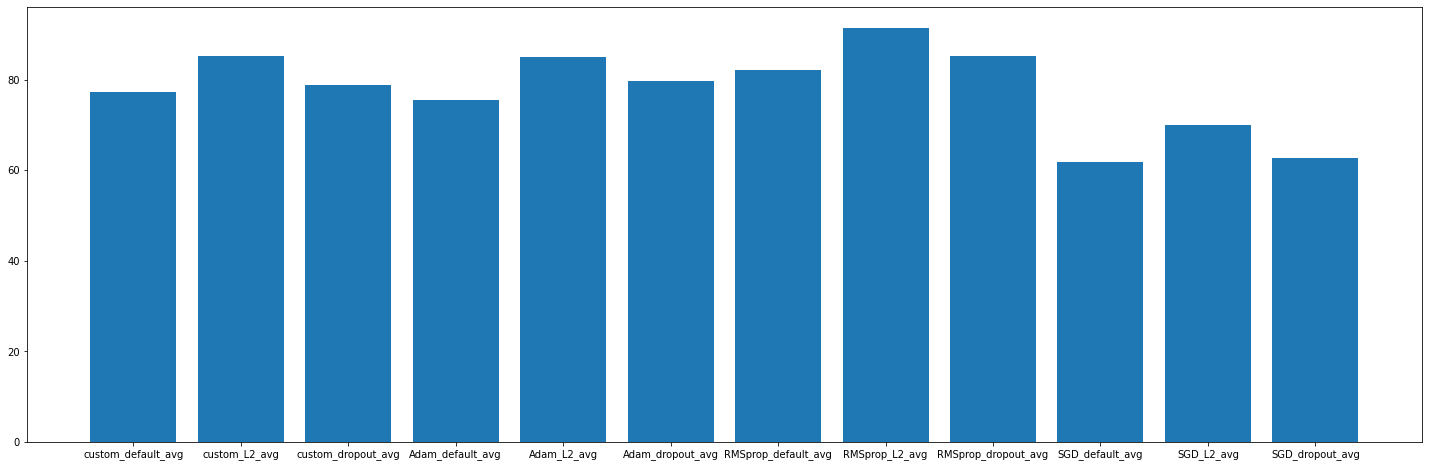

In [11]:
df = pd.DataFrame()

optimizer_list = ["custom", "Adam", "RMSprop", "SGD"]
reg_list = ["default", "L2", "dropout"]

avg_cputime_dict = {}
for optim in optimizer_list:
        for reg in reg_list:
                key  = f"{optim}_{reg}"
                df[key] = data[optim][reg]["cputime_list"]
                avg_cputime_dict[key + "_avg"] = np.mean(df[key])
print ("##CPU time stats across trials##")
print (df)
print ("#Average CPU time per model#")
df = pd.DataFrame(avg_cputime_dict,index = [0])
print (df.iloc[0])
plt.figure(figsize=(25,8))
plt.bar(avg_cputime_dict.keys(), avg_cputime_dict.values())

##Accuracy stats across trials##
   custom_default  custom_L2  custom_dropout  Adam_default  Adam_L2  \
0          0.9716     0.9706          0.9722        0.9653   0.9651   
1          0.9693     0.9687          0.9709        0.9658   0.9645   
2          0.9660     0.9688          0.9715        0.9558   0.9616   
3          0.9651     0.9670          0.9723        0.9605   0.9608   
4          0.9688     0.9701          0.9709        0.9637   0.9633   
5          0.9710     0.9707          0.9721        0.9661   0.9649   
6          0.9678     0.9678          0.9716        0.9640   0.9635   
7          0.9687     0.9681          0.9731        0.9625   0.9591   
8          0.9711     0.9700          0.9702        0.9654   0.9660   
9          0.9667     0.9670          0.9688        0.9638   0.9656   

   Adam_dropout  RMSprop_default  RMSprop_L2  RMSprop_dropout  SGD_default  \
0        0.9641           0.9600      0.9542           0.9555       0.9488   
1        0.9644           0.9

<BarContainer object of 12 artists>

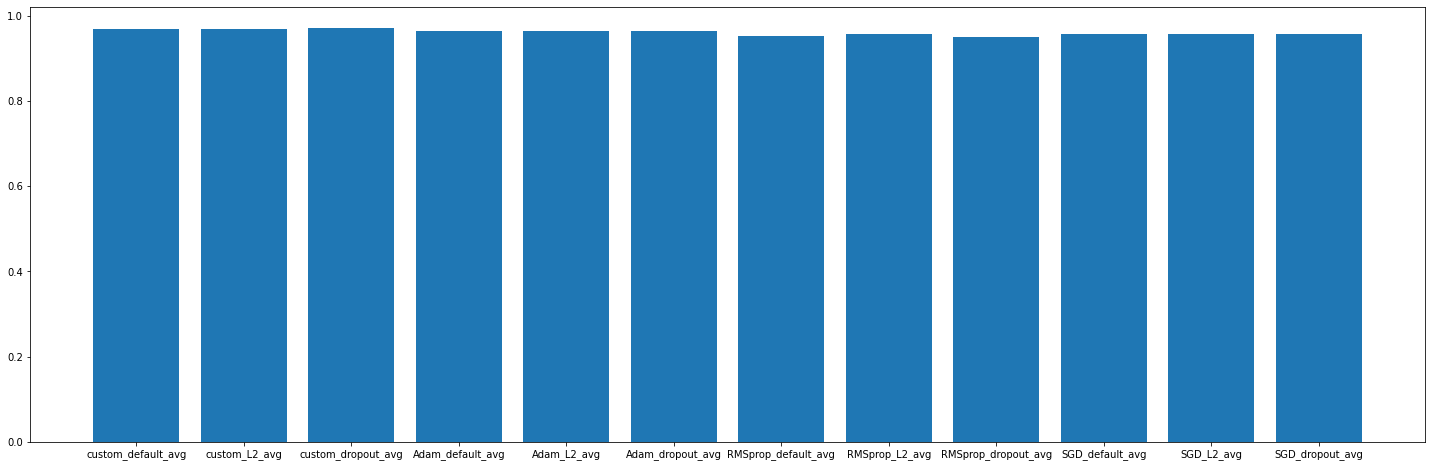

In [12]:
df = pd.DataFrame()

optimizer_list = ["custom", "Adam", "RMSprop", "SGD"]
reg_list = ["default", "L2", "dropout"]

avg_acc_dict = {}
for optim in optimizer_list:
        for reg in reg_list:
                key  = f"{optim}_{reg}"
                df[key] = data[optim][reg]["test_acc_list"]
                avg_acc_dict[key + "_avg"] = np.mean(df[key])
print ("##Accuracy stats across trials##")
print (df)
print("\n\n")

print ("#Average Accuracy per model#")
df = pd.DataFrame(avg_acc_dict,index = [0])
print (df.iloc[0])
plt.figure(figsize=(25,8))
plt.bar(avg_acc_dict.keys(), avg_acc_dict.values())

In [15]:
df = pd.DataFrame()

optimizer_list = ["custom", "Adam", "RMSprop", "SGD"]
reg_list = ["default", "L2", "dropout"]
#seeds =
variance_dict = {}
for optim in optimizer_list:
        for reg in reg_list:
                key  = f"{optim}_{reg}"
                train_cce_list_dict = data[optim][reg]["train_cce_list_dict"]
                avg_cce_list = []
                for seed in train_cce_list_dict.keys():
                        avg_cce_list.append(np.mean(train_cce_list_dict[seed]))
                variance_dict[key] = np.var(avg_cce_list)

print ("#Average Variance in loss across seeds per model#")
df = pd.DataFrame(variance_dict,index = [0])
print (df.iloc[0])

#Average Variance in loss across seeds per model#
custom_default     1.056462e-09
custom_L2          7.386467e-10
custom_dropout     2.057086e-10
Adam_default       1.417280e-09
Adam_L2            1.389877e-09
Adam_dropout       4.274127e-10
RMSprop_default    5.485912e-09
RMSprop_L2         1.038087e-09
RMSprop_dropout    1.731371e-09
SGD_default        8.375600e-10
SGD_L2             8.415907e-10
SGD_dropout        8.812967e-10
Name: 0, dtype: float64
